# This notebook processes the data output from the model

## basic utility functions and imports

In [97]:
import json
from matplotlib.patches import Rectangle
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import statsmodels.api as sm
import pickle as pkl
from scipy import stats
import pyvis.network as pn
import importlib

importlib.reload(pn)


import scipy.stats

"""
calculates the cooperation levels for all agents and specifically for non-civic agents, spatial model
"""
def total_coop_level_spatial(dat):
    civ_coop = 0 if dat["civ"]["pop"] == 0 else dat["civ"]["pop"]*dat["civ"]["coop"]
    coo_coop = 0 if dat["coo"]["pop"] == 0 else dat["coo"]["pop"]*dat["coo"]["coop"]
    final_civ_coop = civ_coop + coo_coop
    sel_coop = 0 if dat["sel"]["pop"] == 0 else dat["sel"]["pop"]*dat["sel"]["coop"]
    sta_coop = 0 if dat["sta"]["pop"] == 0 else dat["sta"]["pop"]*dat["sta"]["coop"]
    
    return final_civ_coop + sel_coop + sta_coop, sel_coop + sta_coop

"""
calculates cooperation levels for all agents and non-civic agents, abstract model
"""
def total_coop_level_pinhead(dat):
    mis_coop = 0 if dat["mis"]["pop"] == 0 else dat["mis"]["pop"]*dat["mis"]["coop"]
    dec_coop = 0 if dat["dec"]["pop"] == 0 else dat["dec"]["pop"]*dat["dec"]["coop"]
    cit_coop = 0 if dat["cit"]["pop"] == 0 else dat["cit"]["pop"]*dat["cit"]["coop"]
    sai_coop = 0 if dat["sai"]["pop"] == 0 else dat["sai"]["pop"]*dat["sai"]["coop"]
    
    civ_coop = 0 if dat["civ"]["pop"] == 0 else dat["civ"]["pop"]*dat["civ"]["coop"]
    sel_coop = 0 if dat["sel"]["pop"] == 0 else dat["sel"]["pop"]*dat["sel"]["coop"]
    sta_coop = 0 if dat["sta"]["pop"] == 0 else dat["sta"]["pop"]*dat["sta"]["coop"]
    
    total_coop = mis_coop + dec_coop + cit_coop + sai_coop + civ_coop + sel_coop + sta_coop
    badboi_coop = dec_coop + mis_coop + sel_coop + sta_coop
    
    return total_coop, badboi_coop

"""
gets total population and the non civic population
"""
def population(dat):
    
    if "cit" in dat:
        addition_total = dat["cit"]["pop"] + dat["sai"]["pop"] + dat["dec"]["pop"] + dat["mis"]["pop"]
        addition_nonciv = dat["dec"]["pop"] + dat["mis"]["pop"]
    else:
        addition_total = dat["coo"]["pop"]
        addition_nonciv = 0
    
    return dat["civ"]["pop"] + dat["sel"]["pop"] + dat["sta"]["pop"] + addition_total, dat["sel"]["pop"] + dat["sta"]["pop"] + addition_nonciv

"""
gets total coop level and the coop level of non civic agents
"""
def total_coop_level(dat):
    if "cit" in dat:
        return total_coop_level_pinhead(dat) # this is the pinhead model
    else:
        return total_coop_level_spatial(dat)

"""
gets the name of the distribution from the fraction of civic agents
"""
def lookup_distrib_name_spatial(num):
    if num == 0.00:
        return "noconscience"
    elif num == 0.02:
        return "conscience"

"""
gets the name of the distribution from the fraction of civic and saints
"""
def lookup_distrib_name_pinhead(tup):
    if tup == (0.01, 0.01):
        return "mix"
    elif tup == (0.02, 0.00):
        return "conscience"
    elif tup == (0.00, 0.02):
        return "coop"
    
"""
calculates the mean, standard deviation, and standard error of a list
"""
def calc_mean_sd_se(lst):
    mean = sum(lst)/len(lst)
    sd = math.sqrt(sum([(x - mean)**2 for x in lst]) / (len(lst) - 1))
    se = sd / math.sqrt(len(lst))
    return mean, sd, se

"""
gets the directory name from the set of parameters
"""
def get_dirname(params, model):
    if model == "spatial":
        defaults = {
            "y": 20050,
            "n": 20,
            "g": 10,
            "c": 20,
            "b": 65,
            "r": 20,
            "t": 0.5,
            "pm": 0.01,
            "ps": 0.01,
            "distrib": 0.02,
            "cd": 5 
        }
    elif model == "pinhead":
        defaults = {
            "y": 15000,
            "n": 35,
            "g": 60,
            "c": 1,
            "b": 3.5,
            "pm": 0.01,
            "ps": 0.2,
            "r": 1,
            "t": 0.5,
            "distrib": "0.02_0",
        }
    
    dirname_list = []
    for var in defaults.keys():
        dirname_list.append(f'{var}{lookup_priority(var, params, defaults)}')
    
    dirname = "_".join(dirname_list)
        
    return dirname

"""
looks up key first in the pri_dict, but if its not in their, it looks in the backup dict
"""
def lookup_priority(key, pri_dict, backup_dict):
    if key in pri_dict:
        return pri_dict[key]
    else:
        return backup_dict[key]
    
"""
generator function that allows you to iterate through all sets of parameters given in the parameter dict
"""
def make_tuples_from_param_dict(params):
    if params:
        first_key = list(params.keys())[0]
        first_vals = params[first_key]
        new_params = {key: params[key] for key in params if key != first_key}

        for val in first_vals:
            for tup in make_tuples_from_param_dict(new_params):
                yield (val,) + tup
    else:
        yield ()

"""
interpolates a list with None elements by carrying values forward, but if a list starts with none values, it carries
the first value backward
"""
def interpolate(lst):
    # make sure you start with non-none entries
    
    new_lst = []
    last_non_none = None
    for i, item in enumerate(lst):
        if lst[i] is not None:
            
            # if this is the first non-none value, fill in all vals before
            if last_non_none is None:
                new_lst += [item] * i
            
            # also add the new value to the list
            new_lst.append(lst[i])
            last_non_none = i
        elif last_non_none is not None:
            new_lst.append(lst[last_non_none])
    
    return new_lst
    
"""
replaces a list with a 50-step rolling average
"""
def smoother(lst, window=50):
    new_lst = [sum(lst[i:i+window])/window for i in range(len(lst) - window)]
    return new_lst

"""
divides each element of the list by the sum
"""
def normalize(lst):
    lst_sum = sum(lst)
    normalized = [elt/lst_sum for elt in lst]
    return normalized

## visual setup

In [98]:
# define the five colors
light = '#E5EFFF'
med = '#8282D1'
dark = '#2B2347'
turq = '#7CCFC9'
red = '#994546'

# specify properties for box plots
medianprops = dict(linewidth=1.5)
meanprops = dict(marker='D', markerfacecolor=turq, markeredgecolor=turq)
flierprops = dict(marker='.')

# specify font 
matplotlib.rcParams['font.family'] = "Courier New"

# remove spines, hide ticks, add a light grid, and label axis
def format_grid(ax, label="(A)", show_horiz_gridlines=True, show_vert_gridlines=False):
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    if show_horiz_gridlines:
        ax.yaxis.grid(color=light, zorder=0)
        
    if show_vert_gridlines:
        ax.xaxis.grid(color=light, zorder=0)
    
    ax.text(ax.get_xlim()[1], ax.get_ylim()[1], label, ha="right", va="top", fontweight='bold', fontsize=15, zorder=8)
    ax.tick_params(axis=u'both', which=u'both',length=0)

# set coloring for box plot boxes
def set_box_colors(bp, color_range=[red, dark, turq]):
    for i, color in enumerate(color_range):
        plt.setp(bp['boxes'][i], color=color)  
        plt.setp(bp['medians'][i], color='black')
        
        if i < len(bp['fliers']):
            plt.setp(bp['fliers'][i], color=color)

        for elem in ['caps', 'whiskers']:
            plt.setp(bp[elem][i*2], color=color)
            plt.setp(bp[elem][i*2 + 1], color=color)

# make some colormaps
cdict = {'red':   [(0.0,  0.6, 0.6),
                   (1.0,  0.49, 0.49)],

         'green': [(0.0, 0.27, 0.27),
                   (1.0, 0.81, 0.81)],

         'blue':  [(0.0,  0.27, 0.27),
                   (1.0,  0.79, 0.79)]}
red_turq_cmap = matplotlib.colors.LinearSegmentedColormap("red_turq_gradient", cdict, N=255)
light_dark_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("light_dark_gradient", ["#E5EFFF","#2B2347"])
light_med_dark_edge_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "light_dark_gradient", 
    [(0, "#E5EFFF"),(0.45,'#8282D1'),(0.55,'#8282D1'),(1.0, "#2B2347")])

# aggregate visualizations

## imports relevant data from model

In [99]:
"""
this function collects the data for the requested model and params and puts it into a dictionary
"""
def create_data_dict(model, params, data_dict=None):
    if data_dict is None:
        data_dict = {mig: {distrib: {benefit: {} for benefit in params["b"]} for distrib in params["distrib"]} for mig in params["ps"]}
    
    for benefit, mig, distrib in make_tuples_from_param_dict(params):
        # get file names from the directory
        # distrib_name = lookup_distrib_name_spatial(distrib)
        subdir = get_dirname({"b": benefit, "ps": mig, "distrib": distrib}, model)
        # subdir = f"{(benefit / 20):.2f}_{distrib_name}"
        dirname = f"{model}/data/{subdir}"
        # print(dirname)
        
        if not os.path.exists(dirname):
            continue
            
        files = os.listdir(dirname)

        if "Icon\r" in files:
            files.remove("Icon\r")
        if "desktop.ini" in files:
            files.remove("desktop.ini")

        breakouts = []
        avg_coops = []
        max_coops = []
        min_coops = []
        avg_noncivic_coops = []
        avg_civic_coops = []
        avg_civs = []
        max_civs = []
        min_civs = []
        eighty_pcts = []
        civ_eighty_pcts = []
        full_coop_levels = []
        full_nc_coop_levels = []
        full_civ_levels = []
        full_civ_coop_levels = []
        total_migs = []
        total_deaths = []

        for file in files:
            f = open(f"{dirname}/{file}")
            data = json.load(f)
            
            
            if model == "spatial":
                total_migs.append(data["demographics"]["migrated"])
                total_deaths.append(data["demographics"]["total"])
                data.pop("demographics")
            
            data.pop("params")

            # construct the dictionary that I want
            coop_levels = []
            noncivic_coop_levels = []
            civic_coop_levels = []
            civ_percentages = []
            pops = []
            groups = []

            on_tail = False
            on_real_tail = False


            # compile the yearly data in a list
            for year, dat in data.items():
                pop, noncivic_pop = population(dat)
                
                if pop > 2000 and not on_tail and model == "spatial":
                    on_tail = True
                    on_real_tail = True
                    breakouts.append(int(year))
                
                elif int(year) > 2000 and model == "pinhead" and not on_tail:
                    on_tail = True
                
                elif int(year) > 5000 and not on_tail:
                    on_tail = True

                elif on_tail:
                    if pop > 2000 and not on_real_tail:
                        on_real_tail = True
                        breakouts.append(int(year))


                    cooperators, noncivic_cooperators = total_coop_level(dat)

                    if model == "spatial":
                        pops.append(pop)
                        groups.append(dat["g"])

                    coop_levels.append(cooperators/pop)

                    if pop != noncivic_pop:   
                        civic_coop_levels.append((cooperators - noncivic_cooperators)/(pop - noncivic_pop))
                    else:
                        civic_coop_levels.append(None)

                    noncivic_coop_levels.append(noncivic_cooperators/noncivic_pop)
                    civ_percentages.append((pop - noncivic_pop)/pop)

            if not on_real_tail:
                breakouts.append("never")

            # for a given run, calculaothe average cooperation levels and the average level of civic learners
            full_coop_levels.append(coop_levels)
            full_nc_coop_levels.append(noncivic_coop_levels)
            full_civ_coop_levels.append(civic_coop_levels)
            full_civ_levels.append(civ_percentages)

            avg_coop = sum(coop_levels)/len(coop_levels)
            deviations = [abs(x - avg_coop) for x in coop_levels]
            deviations.sort()
            eighty_pcts.append(deviations[math.ceil(len(deviations)*0.8)])

            avg_coops.append(avg_coop)
            min_coops.append(min(coop_levels))
            max_coops.append(max(coop_levels))
            avg_noncivic_coops.append(sum(noncivic_coop_levels)/len(noncivic_coop_levels))
            
            civic_coop_non_none = [civic_coop for civic_coop in civic_coop_levels if civic_coop is not None]
            avg_civic_coops.append(sum(civic_coop_non_none)/len(civic_coop_non_none))

            avg_civ = sum(civ_percentages)/len(civ_percentages)
            deviations = [abs(x - avg_civ) for x in civ_percentages]
            deviations.sort()
            civ_eighty_pcts.append(deviations[math.ceil(len(deviations)*0.8)])
            avg_civs.append(avg_civ)
            min_civs.append(min(civ_percentages))
            max_civs.append(max(civ_percentages))

        # calculate effective migration rate
        if model == "spatial":
            eff_mig_rate = sum(total_migs)/sum(total_deaths)
            eff_grp_size_simple = sum(pops)/sum(groups)
            group_sizes = [pop / group for pop, group in zip(pops, groups)]
            eff_grp_size_better = sum(group_sizes)/len(group_sizes)

        # calculate the average cooperation levels
        coop_max_mean, _, coop_max_se = calc_mean_sd_se(max_coops)
        coop_min_mean, _, coop_min_se = calc_mean_sd_se(min_coops)
        coop_sample_mean, _, coop_se = calc_mean_sd_se(avg_coops)
        eighty_pct_mean, _, eighty_pct_se = calc_mean_sd_se(eighty_pcts)

        nc_coop_sample_mean, _, nc_coop_se = calc_mean_sd_se(avg_noncivic_coops)
        civ_coop_sample_mean, _, civ_coop_se = calc_mean_sd_se(avg_civic_coops)

        # calculate the average civic learner levels
        civ_max_mean, _, civ_max_se = calc_mean_sd_se(max_civs)
        civ_min_mean, _, civ_min_se = calc_mean_sd_se(min_civs)
        civ_sample_mean, _, civ_se = calc_mean_sd_se(avg_civs)
        
        civ_eighty_pct_mean, _, civ_eighty_pct_se = calc_mean_sd_se(civ_eighty_pcts)

        # calculate the average civic learner levels
        civ_max_mean, _, civ_max_se = calc_mean_sd_se(max_civs)
        civ_min_mean, _, civ_min_se = calc_mean_sd_se(min_civs)
        civ_sample_mean, _, civ_se = calc_mean_sd_se(avg_civs)

        number_breakouts = [breakout for breakout in breakouts if breakout != "never"]
        breakout_fract = len(number_breakouts)/len(breakouts)
        breakout_fract_se = math.sqrt(breakout_fract*(1 - breakout_fract)/len(breakouts))

        if len(number_breakouts) > 1:
            breakout_mean, _, breakout_se = calc_mean_sd_se(number_breakouts)
        else:
            breakout_mean, breakout_se = 0, 0
        
        if mig not in data_dict:
            data_dict[mig] = {}
        if distrib not in data_dict[mig]:
            data_dict[mig][distrib] = {}
        if benefit not in data_dict[mig][distrib]:
            data_dict[mig][distrib][benefit] = {}
        
        # demographic variables
        if model == "spatial":
            data_dict[mig][distrib][benefit]["eff_mig"] = eff_mig_rate
            data_dict[mig][distrib][benefit]["grp_size"] = eff_grp_size_better
            data_dict[mig][distrib][benefit]["grp_size_check"] = eff_grp_size_simple

        # full lists of things
        data_dict[mig][distrib][benefit]["civ_coop_levels"] = full_civ_coop_levels
        data_dict[mig][distrib][benefit]["coop_levels"] = full_coop_levels
        data_dict[mig][distrib][benefit]["nc_coop_levels"] = full_nc_coop_levels
        data_dict[mig][distrib][benefit]["civ_levels"] = full_civ_levels

        # fraction of groups that reached 2000 population
        data_dict[mig][distrib][benefit]["breakout_fract"] = breakout_fract
        data_dict[mig][distrib][benefit]["breakout_fract_se"] = breakout_fract_se
        data_dict[mig][distrib][benefit]["breakout_mean"] = breakout_mean
        data_dict[mig][distrib][benefit]["breakout_se"] = breakout_se

        # coop mean, min, max
        data_dict[mig][distrib][benefit]["coop_min"] = coop_min_mean
        data_dict[mig][distrib][benefit]["coop_min_se"] = coop_min_se

        data_dict[mig][distrib][benefit]["coop_max"] = coop_max_mean
        data_dict[mig][distrib][benefit]["coop_max_se"] = coop_max_se

        data_dict[mig][distrib][benefit]["coop_mean"] = coop_sample_mean
        data_dict[mig][distrib][benefit]["coop_se"] = coop_se

        data_dict[mig][distrib][benefit]["eighty_pct_mean"] = eighty_pct_mean
        data_dict[mig][distrib][benefit]["eighty_pct_se"] = eighty_pct_se
        
        data_dict[mig][distrib][benefit]["civ_coop_mean"] = civ_coop_sample_mean
        data_dict[mig][distrib][benefit]["civ_coop_se"] = civ_coop_se
        
        data_dict[mig][distrib][benefit]["nc_coop_mean"] = nc_coop_sample_mean
        data_dict[mig][distrib][benefit]["nc_coop_se"] = nc_coop_se

        data_dict[mig][distrib][benefit]["civ_min"] = civ_min_mean
        data_dict[mig][distrib][benefit]["civ_min_se"] = civ_min_se

        data_dict[mig][distrib][benefit]["civ_max"] = civ_max_mean
        data_dict[mig][distrib][benefit]["civ_max_se"] = civ_max_se

        data_dict[mig][distrib][benefit]["civ_mean"] = civ_sample_mean
        data_dict[mig][distrib][benefit]["civ_se"] = civ_se

        data_dict[mig][distrib][benefit]["civ_eighty_pct_mean"] = civ_eighty_pct_mean
        data_dict[mig][distrib][benefit]["civ_eighty_pct_se"] = civ_eighty_pct_se

    for benefit in params["b"]:
        for mig in params["ps"]:
            for distrib in params["distrib"]:
                if benefit not in data_dict[mig][distrib] or not data_dict[mig][distrib][benefit]:
                    continue
                if model == "spatial":
                    demographics =  f'{data_dict[mig][distrib][benefit]["eff_mig"]:.3f} {data_dict[mig][distrib][benefit]["grp_size"]:.3f}'
                    distrib_string =  f'{distrib:.2f}'
                else:
                    demographics = ""
                    distrib_string = distrib
                    
                print(f'{benefit:.2f}', 
                      f'{mig:.2f}', 
                      distrib_string, 
                      f'{data_dict[mig][distrib][benefit]["coop_mean"]:.3f}', 
                      f'{data_dict[mig][distrib][benefit]["nc_coop_mean"]:.3f}', 
                      f'{data_dict[mig][distrib][benefit]["civ_mean"]:.3f}',
                      demographics
                     )

    return data_dict

"""
prints the data dict line by line so we get some sense of the mean values for each parameter combo
"""
def print_dict_important_parts(model, data_dict, params):
    for benefit in params["b"]:
        for mig in params["ps"]:
            for distrib in params["distrib"]:
                if benefit not in data_dict[mig][distrib] or not data_dict[mig][distrib][benefit]:
                    continue

                if model == "spatial":
                    demographics =  f'{data_dict[mig][distrib][benefit]["eff_mig"]:.3f} {data_dict[mig][distrib][benefit]["grp_size"]:.3f}'
                    distrib_string =  f'{distrib:.2f}'
                else:
                    demographics = ""
                    distrib_string = distrib

                print(f'{benefit:.2f}', 
                      f'{mig:.2f}', 
                      distrib_string, 
                      f'{data_dict[mig][distrib][benefit]["coop_mean"]:.3f}', 
                      f'{data_dict[mig][distrib][benefit]["nc_coop_mean"]:.3f}', 
                      f'{data_dict[mig][distrib][benefit]["civ_mean"]:.3f}',
                      demographics
                     )

## data collection for abstract (pinhead) and naturalistic (spatial) models

In [100]:
# the collection that I ran

# ben     mig aggr                      mig deet
# 55  ->  0.5                        -> 0.4
# 60  ->  0 - 0.8                    -> 
# 65  ->  0, 0.005, 0.05, 0 - 0.8    -> 0.4
# 70  ->  0 - 0.8                    -> 0.4
# 75  ->  0.5


# PINHEAD

# ben       mig aggr     mig deet
# 3     ->  0.2       -> 0.2
# 3.25  ->  0 - 0.6   -> 
# 3.5   ->  0 - 0.6   -> 0.2
# 3.75  ->  0 - 0.6   -> 0.2
# 4     ->  0.2
# 4.25  ->  0.2

In [101]:
params_spatial = {
 "b": [55, 60, 65, 70, 75],
 "ps": [0, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
 "distrib": [0, 0.02]
}

In [ ]:
spatial_data_dict = create_data_dict("spatial", params_spatial)

In [ ]:
params_pinhead = {
 "b": [3, 3.25, 3.5, 3.75, 4],
 "ps": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
 "distrib": ["0_0.02", "0.02_0"]
}

In [ ]:
pinhead_data_dict = create_data_dict("pinhead", params_pinhead)

## load or save pickle files of the data dictionary

In [ ]:
with open("pickle/spatial_data_dict.pkl", "wb") as spatial_f:
    pkl.dump(spatial_data_dict, spatial_f)

with open("pickle/pinhead_data_dict.pkl", "wb") as pinhead_f:
    pkl.dump(pinhead_data_dict, pinhead_f)

In [ ]:
with open("pickle/spatial_data_dict.pkl", "rb") as spatial_f:
    spatial_data_dict = pkl.load(spatial_f)
    
with open("pickle/pinhead_data_dict.pkl", "rb") as pinhead_f:
    pinhead_data_dict = pkl.load(pinhead_f)

## plot time series

In [ ]:
"""
plots a smoothed time series of cooperation levels and populations of agent types over the course of a particular run
specified by [ind]
"""
def plot_civ_nc_time_series(ind, model, data_dict, benefit, mig, window=500):
    if model == "pinhead":
        civ_distrib = "0.02_0"
        other_distrib = "0_0.02"
    elif model == "spatial":
        civ_distrib = 0.02
        other_distrib = 0
        
    civ_coops = data_dict[mig][civ_distrib][benefit]["civ_coop_levels"][ind]
    nc_coops = data_dict[mig][civ_distrib][benefit]["nc_coop_levels"][ind]
    coops = data_dict[mig][civ_distrib][benefit]["coop_levels"][ind]
    nc_coops_nociv = data_dict[mig][other_distrib][benefit]["nc_coop_levels"][ind]
    coops_nociv = data_dict[mig][other_distrib][benefit]["coop_levels"][ind]
    pops_civ = data_dict[mig][other_distrib][benefit]["civ_levels"][ind]
    civ_coops_interpolated = interpolate(civ_coops)
    
    civ_coops_pops = [pop * coop for pop, coop in zip(pops_civ, civ_coops_interpolated)]
    
    civ_coops_smoothed = normalize(smoother(civ_coops_interpolated, window=window))
    coops_smoothed_non_norm = smoother(coops, window=window)
    coops_smoothed = normalize(coops_smoothed_non_norm)
    
    nc_coops_smoothed = normalize(smoother(nc_coops, window=window))
    coops_nociv_smoothed = smoother(coops_nociv, window=window)
    nc_coops_nociv_smoothed = normalize(smoother(nc_coops_nociv, window=window))
    pops_civ_smoothed = normalize(smoother(pops_civ, window=window))
    civ_coops_pops_smoothed = normalize(smoother(civ_coops_pops, window=window))
    
    
    
    fig1, ax1 = plt.subplots(1)
    ax1.set_title("experimental: civ coops and nc coops")
    ax1.plot(range(len(civ_coops_smoothed)), civ_coops_smoothed)
    ax1.plot(range(len(civ_coops_smoothed)), nc_coops_smoothed)
    
    fig2, ax2 = plt.subplots(1)
    ax2.set_title("experimental: civ_coops*civ_poops and nc_coops")
    ax2.plot(range(len(civ_coops_smoothed)), civ_coops_pops_smoothed)
    ax2.plot(range(len(civ_coops_smoothed)), nc_coops_smoothed)
    
    fig3, ax3 = plt.subplots(1)
    ax3.set_title("experimental: civ coops and civ population")
    ax3.plot(range(len(civ_coops_smoothed)), civ_coops_smoothed)
    ax3.plot(range(len(civ_coops_smoothed)), pops_civ_smoothed)
    
    fig4, ax4 = plt.subplots(1)
    ax4.set_title("experimental: total coops and civ population")
    ax4.plot(range(len(civ_coops_smoothed)), pops_civ_smoothed)
    ax4.plot(range(len(civ_coops_smoothed)), coops_smoothed)
    
    fig5, ax5 = plt.subplots(1)
    ax5.set_title("total coops, total coops")
    ax5.plot(range(len(civ_coops_smoothed)), coops_nociv_smoothed)
    ax5.plot(range(len(civ_coops_smoothed)), coops_smoothed_non_norm)
    
    return fig1, fig2, fig3, fig4, fig5

## functions for analyzing spikes in cooperation

In [ ]:
"""
calls find spikes on a list of cooperation lists [coop_lists]
"""
def get_all_spikes(coop_lists, min_spike_length=0):
    spikes_list = []
    
    for coop_list in coop_lists:
        spikes, _, _ = find_spikes(coop_list, min_spike_length)
        spikes_list.append(spikes)
    
    return spikes_list

"""
for a particular list of cooperation levels, returns a list of two-element lists that represent intervals
in which cooperation was above average (possibly with some min_spike_length)
"""
def find_spikes(coop_levels, min_spike_length=0):
    avg = sum(coop_levels) / len(coop_levels)
    
    spikes = []
    curr_spike = []
    on_spike = False
    max_spike_length = 0
    avg_spike_length = [0, 0]
    
    for i, lvl in enumerate(coop_levels):
        # rose above, add fist index
        if avg < lvl and not on_spike:
            on_spike = True
            curr_spike.append(i)
            
        # dropped below, reset and save spike
        if avg >= lvl and on_spike:
            curr_spike_length = i - curr_spike[0]
            max_spike_length =  max_spike_length if curr_spike_length < max_spike_length else curr_spike_length
            curr_spike.append(i)
            on_spike = False
            
            if curr_spike_length > min_spike_length and curr_spike[0] != 0:
                avg_spike_length[1] += 1
                weight = 1 / avg_spike_length[1]
                avg_spike_length[0] = avg_spike_length[0]*(1 - weight) + curr_spike_length*weight
                
                if len(spikes) > 0:
                    last_spike = spikes[len(spikes) - 1]
                    assert last_spike[1] < curr_spike[0]
                
                spikes.append(curr_spike)
                
            curr_spike = []
    
            
    return spikes, max_spike_length, avg_spike_length[0]

"""
collects an array where each row is the values of cooperation on a spike/drop (extended 100 roudns before/after
the start/end of spike/drop). Then, the average array takes the mean coop value for each step on the interval.
the idea was to see if i could find the shape of a prototypical spike
"""
def calc_average_spike_drop_across_runs(coop_lists, spike_lists, interval, extension=100):
    drop_arrs = []
    spike_arrs = []
    for spike_list, coop_list in zip(spike_lists, coop_lists):
        drop_arr, _  = calc_average_drop(coop_list, spike_list, interval, extension)
        spike_arr, _ = calc_average_spike(coop_list, spike_list, interval, extension)
        drop_arrs.append(drop_arr)
        spike_arrs.append(spike_arr)
    
    full_spike_arr = np.concatenate(spike_arrs, axis=0)
    full_drop_arr = np.concatenate(drop_arrs, axis=0)
    
    full_spike_avgs = full_spike_arr.sum(axis=0) / full_spike_arr.shape[0]
    full_drop_avgs = full_drop_arr.sum(axis=0) / full_drop_arr.shape[0]
    
    return full_spike_arr, full_spike_avgs, full_drop_arr, full_drop_avgs

"""
colects a list of the type of spike, specifically: who instigated it? who preserved it?
also returns counts of the spikes instigated/preserved by civ and nc agents
"""
def compare_civ_nc_spikes(spike_lists, civ_spike_lists, nc_spike_lists):
    
    civ_inst_count = 0
    civ_pres_count = 0
    nc_inst_count = 0
    nc_pres_count = 0
    tot_spike_count = 0
    spike_type_lists = []
    
    for i, spike_list in enumerate(spike_lists):
        civ_spike_ind = 0
        nc_spike_ind = 0
        spike_type_list = []
        
        for spike in spike_list:
            # print("---\n", spike)
            civ_encompasser_start, civ_spike_ind = find_encompasser(spike[0], civ_spike_lists[i], civ_spike_ind)
            civ_encompasser_end, civ_spike_ind = find_encompasser(spike[1], civ_spike_lists[i], civ_spike_ind)
            
            nc_encompasser_start, nc_spike_ind = find_encompasser(spike[0], nc_spike_lists[i], nc_spike_ind)
            nc_encompasser_end, nc_spike_ind = find_encompasser(spike[1], nc_spike_lists[i], nc_spike_ind)
            
            # print(civ_encompasser_start, civ_encompasser_end)
            # print(nc_encompasser_start, nc_encompasser_end)
    
            
            spike_type = {"instigator": get_instigator_winner(civ_encompasser_start, nc_encompasser_start),
                          "preserver": get_preserver_winner(civ_encompasser_end, nc_encompasser_end),
                          "length": spike[1] - spike[0]}
            
            tot_spike_count += 1
            civ_inst_count += (spike_type["instigator"] in ["civ", "tie"])
            civ_pres_count += (spike_type["preserver"] in ["civ", "tie"])
            nc_inst_count += (spike_type["instigator"] in ["nci", "tie"])
            nc_pres_count += (spike_type["preserver"] in ["nci", "tie"])
            
            spike_type_list.append(spike_type)
            # print(spike_type)
            # print(tot_spike_count, civ_inst_count, civ_pres_count, nc_inst_count, nc_pres_count)
        
        spike_type_lists.append(spike_type_list)
    
    return tot_spike_count, civ_inst_count, civ_pres_count, nc_inst_count, nc_pres_count, spike_type_lists

"""
looks at two intervals surrounding the start of a spike (representing civic and noncivic spikes),
whichever one starts first is the instigator winner
"""
def get_instigator_winner(civ_encompasser, nc_encompasser):
    civ_start = float('inf') if civ_encompasser is None else civ_encompasser[0] # can never win if no encompasser
    nc_start = float('inf') if nc_encompasser is None else nc_encompasser[0] # can never win if no encompasser
    
    if civ_start < nc_start:
        return "civ"
    elif nc_start < civ_start:
        return "nci"
    elif civ_start == nc_start:
        return "tie"

"""
looks at two intervals surrounding the end of the spike, whichever one ends last is the preserver winner
"""
def get_preserver_winner(civ_encompasser, nc_encompasser):
    civ_end = float('-inf') if civ_encompasser is None else civ_encompasser[1] # can never win if no encompasser
    nc_end = float('-inf') if nc_encompasser is None else nc_encompasser[1] # can never win if no encompasser
    
    if civ_end > nc_end:
        return "civ"
    elif nc_end > civ_end:
        return "nci"
    elif nc_end == civ_end:
        return "tie"

"""
finds the spike that starts before and ends after a particular time, returns none if there is none
"""
def find_encompasser(time, spike_list, ind):
    closest_spike = spike_list[ind]
    while ind < len(spike_list) - 1 and spike_list[ind + 1][0] <= time:
        closest_spike = spike_list[ind + 1]
        ind += 1
    
    encompasser = closest_spike if (closest_spike[0] <= time and closest_spike[1] >= time) else None
    
    return encompasser, ind

"""
this calculates a prototypical drop by looking at an interval of time leading up to the end of the spike, 
in addition to post_spike rounds afterwards. simply averages the cooperation levels on this "drop" stage
"""
def calc_average_drop(coop_levels, spikes, interval, post_spike=100):
    drop_arr = np.zeros((len(spikes), interval))
    
    for i, spike in enumerate(spikes):
        end = min(spike[1] + post_spike, len(coop_levels))
        start = end - interval
        
        if start > 0:
            drop_arr[i,0:interval] = coop_levels[start:end]
    
    drop_arr = drop_arr[drop_arr.sum(axis=1) > 0,:]
    avg_drop = drop_arr.sum(axis=0) / drop_arr.shape[0]
    
    return drop_arr, avg_drop

"""
gets the properties of spikes and troughs, namely their length and their average cooperation level
"""
def get_spike_trough_properties(coop_lists, spike_lists):
    spike_prop_lists = [] # {"avg_val": , "peak_index": , "peak_value": , "length": }
    trough_prop_lists = []
    
    for spike_list, coop_list in zip(spike_lists, coop_lists):
        last_spike = None
        spike_prop_list = []
        trough_prop_list = []
        
        for i, spike in enumerate(spike_list):
            trough_start = 0 if last_spike is None else last_spike[1]
            trough_coops = coop_list[trough_start:spike[0]]
            spike_coops = coop_list[spike[0]:spike[1]]

            spike_prop_list.append(get_props(spike_coops))
            trough_prop_list.append(get_props(trough_coops))
            last_spike = spike
            
            if i == len(spike_list) - 1:
                trough_coops = coop_list[spike[1]:]
                trough_prop_list.append(get_props(trough_coops))
        
        spike_prop_lists.append(spike_prop_list)
        trough_prop_lists.append(trough_prop_list)
    
    return spike_prop_lists, trough_prop_lists

"""
gets the props of a spike corresponding to the cooperation values in lst
"""
def get_props(lst):
    props = {}
    props["length"] = len(lst)
    props["avg_val"] = sum(lst) / props["length"]
    
    peak_ind = np.argmax(lst)
    props["peak_index"] = peak_ind
    props["peak_value"] = lst[peak_ind]
    
    trough_ind = np.argmin(lst)
    props["trough_index"] = trough_ind
    props["trough_value"] = lst[trough_ind]
    
    return props

"""
returns lists of the avg coop values of spikes and troughs, along with who instigated which spikes
"""
def get_spike_type_by_trough_prop(trough_prop_lists, spike_prop_lists, spike_type_lists):
    trough_coops = []
    trough_lengths = []
    spike_coops = []
    spike_lengths = []
    spike_instigators = []
    spike_preservers = []

    for trough_prop_list, spike_prop_list, spike_type_list in zip(trough_prop_lists, spike_prop_lists, spike_type_lists):
        counter = 0
        for trough_prop, spike_prop, spike_type in zip(trough_prop_list, spike_prop_list, spike_type_list):
            trough_lengths.append(trough_prop["length"])
            trough_coops.append(trough_prop["avg_val"])
            spike_lengths.append(spike_prop["length"])
            spike_coops.append(spike_prop["avg_val"])
            spike_preservers.append(spike_type["preserver"])
            spike_instigators.append(spike_type["instigator"])
            counter += 1
        
        last_trough_prop = trough_prop_list[counter]
        trough_lengths.append(trough_prop["length"])
        trough_coops.append(trough_prop["avg_val"])
        
        # print(len(trough_coops), len(spike_coops))
    return trough_coops, trough_lengths, spike_coops, spike_lengths, spike_instigators, spike_preservers

"""
calculates a prototypical spike by looking at [pre_spike] rounds before the spike and interval total steps,
and averaging cooperation values at each of the time steps
"""
def calc_average_spike(coop_levels, spikes, interval, pre_spike=100):
    spike_arr = np.zeros((len(spikes), interval))

    for i, spike in enumerate(spikes):
        start = max(0, spike[0] - pre_spike)
        end = start + interval
        
        if end <= len(coop_levels):
            spike_arr[i,0:interval] = coop_levels[start:end]
    
    spike_arr = spike_arr[spike_arr.sum(axis=1) > 0,:]
    avg_spike = spike_arr.sum(axis=0) / spike_arr.shape[0]
    
    return spike_arr, avg_spike

"""
constructs a matrix of transition probabilities from no spike, to different types of spikes
(defined by who instigated and who preserved the spike)
"""
def construct_markov_process(spike_lists, spike_prop_lists, threshold=200):
    trans_mat = np.zeros((5, 5))
    ind_dict = {"none": 0, "civciv": 1, "civnci": 2, "nciciv": 3, "ncinci": 4}
    
    for spike_list, spike_prop_list in zip(spike_lists, spike_prop_lists):
        last_spike = None
        
        for spike, prop in zip(spike_list, spike_prop_list):
            ind = civ_nci_dict_lookup(ind_dict, prop)
            
            if last_spike is None:
                other_ind = 0
            elif spike[0] - last_spike[1] > threshold:
                other_ind = 0
                trans_mat[last_ind, other_ind] += 1
            else:
                other_ind = last_ind
            
            trans_mat[other_ind, ind] += 1
            
            last_spike = spike
            last_ind = ind
    
    return trans_mat

"""
lookup a val in dict by constructing correct key
"""
def civ_nci_dict_lookup(civ_nci_dict, prop):
    inst = act_inst if (act_inst := prop["instigator"]) != "tie" else np.random.choice(["civ", "nci"])
    pres = act_pres if (act_pres := prop["preserver"]) != "tie" else np.random.choice(["civ", "nci"])
    
    val = civ_nci_dict[inst + pres]
        
    return val

"""
looks up average length of each type of spike (define by who it is instigated by and who it is preserved by)
"""
def get_avg_length_of_each_type(spike_prop_lists):
    counts = np.zeros((4))
    lengths = np.zeros((4))
    
    ind_dict = {"civciv": 0, "civnci": 1, "nciciv": 2, "ncinci": 3}
    for spike_prop_list in spike_prop_lists:
        for prop in spike_prop_list:
            ind = civ_nci_dict_lookup(ind_dict, prop)
            lengths[ind] += prop["length"]
            counts[ind] += 1
    
    return lengths, counts

"""
returns a sequence of characterizations of 25-round chunks -- either very low cooperation, low cooperation,
low civ high nc, high civ low nc, or high civ high nc
"""
def get_sequence_of_characterizations(civ_coop_lists, nc_coop_lists, coop_lists, window=25):
    ind_dict = {(False, False): 1, (False, True): 2, (True, False): 3, (True, True): 4}
    char_lists = []
    for civ_coop_list, nc_coop_list, coop_list in zip(civ_coop_lists, nc_coop_lists, coop_lists):
        avg_civ_coop, sd_civ_coop, _ = calc_mean_sd_se(civ_coop_list)
        avg_nc_coop, sd_nc_coop, _ = calc_mean_sd_se(nc_coop_list)
        avg_coop, sd_coop, _ = calc_mean_sd_se(coop_list)
        char_list = []
        for i, (civ_coop, nc_coop, coop) in enumerate(zip(civ_coop_list, nc_coop_list, coop_list)):
            if i % window == 0:               
                civ_above = (civ_coop > avg_civ_coop)
                nc_above = (nc_coop > avg_nc_coop)

                ind = ind_dict[(civ_above, nc_above)]
                
                if not civ_above and not nc_above and coop < (avg_coop - (0.5 * sd_coop)):
                    ind = 0
                
                # print(civ_coop, avg_civ_coop)
                # print(nc_coop, avg_nc_coop)
                # print(coop, avg_coop, sd_coop)
                # print(ind)
                # y = input("x")
                char_list.append(ind)
        
        char_lists.append(char_list)
        
    return char_lists

"""
given a set of cutoffs, puts the val in the range of cutoffs
"""
def find_range(val, cutoffs):
    ind = 0
    for cutoff in cutoffs:
        if val > cutoff:
            ind += 1
    
    return ind
        

"""
creates a markov process out of the list of characterizations (from get_sequence_characterizations())
"""
def sequence_markov_construction(char_lists):
    trans_mat = np.zeros((5, 5), dtype=int)
    for char_list in char_lists:
        last_char = None
        for char in char_list:
            if last_char is not None:
                trans_mat[last_char, char] += 1
            
            last_char = char
            
    return trans_mat
        
            
"""
gets spikes, the list of their properties, and the troughs and the list of their properties
"""
def get_spikes_and_props(lst):
    spike_lists = get_all_spikes(lst, min_spike_length=10)
    spike_props, trough_props = get_spike_trough_properties(lst, spike_lists)
    
    return spike_lists, spike_props, trough_props

"""
gives experimental and control keys for spatial and pinhead model
"""
def get_distrib_keys(model):
    if model == "spatial":
        exp = 0.02
        control = 0
    elif model == "pinhead":
        exp = "0.02_0"
        control = "0_0.02"
    
    return exp, control

"""
gets the info about spike types and props
"""
def get_spike_info(model, data_dict, benefit, mig):
    exp, control = get_distrib_keys(model)
    
    coop_lists = [smoother(coop_list, window=25) for coop_list in data_dict[mig][exp][benefit]["coop_levels"]]
    nc_coop_lists = [smoother(nc_coop_list, window=25) for nc_coop_list in data_dict[mig][exp][benefit]["nc_coop_levels"]]
    civ_coop_lists = [smoother(interpolate(civ_coop_list), window=25) for civ_coop_list in data_dict[mig][exp][benefit]["civ_coop_levels"]]
    
    c_coop_lists = [smoother(coop_list, window=25) for coop_list in data_dict[mig][control][benefit]["coop_levels"]]
    c_nc_coop_lists = [smoother(nc_coop_list, window=25) for nc_coop_list in data_dict[mig][control][benefit]["nc_coop_levels"]]
    c_civ_coop_lists = [smoother(interpolate(civ_coop_list), window=25) for civ_coop_list in data_dict[mig][control][benefit]["civ_coop_levels"]]
    
    exp_spike_lists, exp_spike_props, exp_trough_props = get_spikes_and_props(coop_lists)
    con_spike_lists, con_spike_props, con_trough_props = get_spikes_and_props(c_coop_lists)
    civ_spike_lists, civ_spike_props, civ_trough_props = get_spikes_and_props(civ_coop_lists)  
    nci_spike_lists, nci_spike_props, nci_trough_props = get_spikes_and_props(nc_coop_lists)
        
    return (exp_spike_lists, exp_spike_props, exp_trough_props, 
            con_spike_lists, con_spike_props, con_trough_props, 
            civ_spike_lists, civ_spike_props, civ_trough_props, 
            nci_spike_lists, nci_spike_props, nci_trough_props)

In [ ]:
"""
flattens a list of lists into a list
"""
def flatten(lol):
    cum = []
    [(cum := cum + v) for v in lol]
    return cum

"""
reshapes an array into a bigger one, with the new slots as zeros
"""
def extend_dim(extended_dims, arr):
    extended = np.zeros(extended_dims)
    slice_tuple = tuple(slice(0, dim) for dim in arr.shape)
    extended[slice_tuple] = arr
    
    return extended

"""
makes the block diagram to show spike and trough lengths 
"""
def make_block_diagram(spike_props_1, trough_props_1, spike_props_2, trough_props_2, title="Block diagram", label="", legend=True):
    spike_props_1 = flatten(spike_props_1)
    trough_props_1 = flatten(trough_props_1)
    spike_props_2 = flatten(spike_props_2)
    trough_props_2 = flatten(trough_props_2)
    
    plength_mean = {}
    plength_sd = {}
    plength_se = {}
    p_share = {}
    
    pval_mean = {}
    pval_se = {}
    
    tlength_mean = {}
    tlength_sd = {}
    tlength_se = {}
    t_share = {}
    
    tval_mean = {}
    tval_se = {}
    
    spike_contrib_fig, sc_ax = plt.subplots(figsize=(5,2))
    plength_mean[0], plength_sd[0], plength_se[0] = calc_mean_sd_se([prop["length"] for prop in spike_props_1])
    tlength_mean[0], tlength_sd[0], tlength_se[0] = calc_mean_sd_se([prop["length"] for prop in trough_props_1])
    p_share[0] = plength_mean[0] / (plength_mean[0] + tlength_mean[0])
    t_share[0] = tlength_mean[0] / (plength_mean[0] + tlength_mean[0])
    
    pval_mean[0], _, pval_se[0] = calc_mean_sd_se([prop["avg_val"] for prop in spike_props_1])
    tval_mean[0], _, tval_se[0] = calc_mean_sd_se([prop["avg_val"] for prop in trough_props_1])
    colors = [turq, med]
    
    sc_ax.add_patch(patches.Rectangle((0, 0), p_share[0], pval_mean[0], facecolor=turq, alpha=0.3, zorder=4, label="NI"))
    plot_block_error_bar(sc_ax, p_share[0] / 2, p_share[0] / 2, pval_mean[0] - pval_se[0] * 2.58, pval_mean[0] + pval_se[0] * 2.58)
    sc_ax.add_patch(patches.Rectangle((p_share[0], 0), t_share[0], tval_mean[0], facecolor=turq, alpha=0.3, zorder=4))
    plot_block_error_bar(sc_ax, p_share[0] + t_share[0] / 2, p_share[0]  + t_share[0] / 2, tval_mean[0] - tval_se[0] * 2.58, tval_mean[0] + tval_se[0] * 2.58)
    
    plength_mean[1], plength_sd[1], plength_se[1] = calc_mean_sd_se([prop["length"] for prop in spike_props_2])
    tlength_mean[1], tlength_sd[1], tlength_se[1] = calc_mean_sd_se([prop["length"] for prop in trough_props_2])
    p_share[1] = plength_mean[1] / (plength_mean[1] + tlength_mean[1])
    t_share[1] = tlength_mean[1] / (plength_mean[1] + tlength_mean[1])
    
    pval_mean[1], _, pval_se[1] = calc_mean_sd_se([prop["avg_val"] for prop in spike_props_2])
    tval_mean[1], _, tval_se[1] = calc_mean_sd_se([prop["avg_val"] for prop in trough_props_2])
    
    sc_ax.add_patch(patches.Rectangle((0, 0), p_share[1], pval_mean[1], facecolor=med, alpha=0.3, zorder=4, label="Non-NI"))
    plot_block_error_bar(sc_ax, p_share[1] / 2, p_share[1] / 2, pval_mean[1] - pval_se[1] * 2.58, pval_mean[1] + pval_se[1] * 2.58)
    sc_ax.add_patch(patches.Rectangle((p_share[1], 0), t_share[1], tval_mean[1], facecolor=med, alpha=0.3, zorder=4))
    plot_block_error_bar(sc_ax, p_share[1] + t_share[1] / 2, p_share[1]  + t_share[1] / 2, tval_mean[1] - tval_se[1] * 2.58, tval_mean[1] + tval_se[1] * 2.58)
    
    shorter = 0 if plength_mean[0] + tlength_mean[0] < plength_mean[1] + tlength_mean[1] else 1
    longer = int(not shorter)
    scale_factor = p_share[longer] / plength_mean[longer]
    
    
    long_error_bar = plength_se[longer] * scale_factor
    plot_block_error_bar(sc_ax, p_share[longer] - 2.58 * long_error_bar, p_share[longer] + 2.58*long_error_bar, pval_mean[longer] - 0.02, pval_mean[longer] - 0.02)
    
    assert abs(scale_factor - (t_share[longer] / tlength_mean[longer])) < 0.000001
    
    scale_plength = (plength_mean[shorter] / plength_mean[longer]) * p_share[longer]
    scale_tlength = (tlength_mean[shorter] / tlength_mean[longer]) * t_share[longer]
    short_error_bar = plength_se[shorter] * scale_factor
    
    print("1", "spike l mean, sd, se", plength_mean[0], plength_sd[0], plength_se[0])
    print("2", "spike l mean, sd, se", plength_mean[1], plength_sd[1], plength_se[1])
    
    print("1", "trough l mean, sd, se", tlength_mean[0], tlength_sd[0], tlength_se[0])
    print("2", "trough l mean, sd, se", tlength_mean[1], tlength_sd[1], tlength_se[1])
    
    print("1", "spike v mean", pval_mean[0])
    print("2", "spike v mean", pval_mean[1])
    
    print("1", "trough v mean", tval_mean[0])
    print("2", "trough v mean", tval_mean[1])
    
    start = 0
    color = colors[shorter]
    sc_ax.plot([start, start + scale_plength], [pval_mean[shorter], pval_mean[shorter]], color=color, zorder=5, label="Abs. length")
    while start < 1:
        sc_ax.plot([start, start + scale_plength], [pval_mean[shorter], pval_mean[shorter]], color=color, zorder=5)
        start = start + scale_plength
        sc_ax.plot([start, start], [pval_mean[shorter], tval_mean[shorter]], color=color, zorder=5)
        
        # and the error bar
        plot_block_error_bar(sc_ax, start - 2.58*short_error_bar, start + 2.58*short_error_bar, pval_mean[shorter] - 0.02, pval_mean[shorter] - 0.02)
        
        sc_ax.plot([start, start + scale_tlength], [tval_mean[shorter], tval_mean[shorter]], color=color, zorder=5)
        start = start + scale_tlength
        sc_ax.plot([start, start], [tval_mean[shorter], pval_mean[shorter]], color=color, zorder=5)
    
    
    
    sc_ax.set_ylabel("Cooperation level")
    sc_ax.set_xlabel("Percentage of round")
    sc_ax.set_title(title, y=1.02)
    sc_ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    sc_ax.set_yticks([0.05, 0.15, 0.25, 0.35, 0.45, 0.55])
    
    if legend:
        sc_ax.legend()
    
    sc_ax.set_xlim(left=0, right=1)
    sc_ax.set_ylim(bottom=0, top=max(pval_mean[0] + 3 * pval_se[0], pval_mean[1] + 3 * pval_se[1]))
    
    format_grid(sc_ax, label=label, show_horiz_gridlines=False, show_vert_gridlines=False)
    
    return spike_contrib_fig

"""
adds error bars to the blcok diagram
"""
def plot_block_error_bar(ax, x_start, x_end, y_start, y_end):
    x_mp = (x_start + x_end) / 2 
    y_mp = (y_start + y_end) / 2
    
    ax.plot([x_start, x_end], [y_start, y_end], color=med, linewidth=0.5, zorder=6)
    ax.plot(x_mp, y_mp, marker="o", markersize=1.5, markeredgecolor=med, markerfacecolor=med, zorder=7)

"""
draws the peaks as dark lines
"""  
def peak_traces(spike_lists_1, spike_lists_2, label_1="", label_2=""):
    # INCLUDE: plot for showing when peaks occur on various runs
    fig0, (trace_ax0, trace_ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 1.75))
    # dot_color_dict = {"civciv": turq, "civnci": med, "nciciv": dark, "ncinci": red}
    
    for i, spike_list in enumerate(spike_lists_1):
        for spike in spike_list:
            trace_ax0.plot(spike, [i, i], color=med, zorder=3)
    
    for i, spike_list in enumerate(spike_lists_2):
        for spike in spike_list:
            trace_ax1.plot(spike, [i, i], color=med, zorder=3)
    
    trace_ax0.set_ylabel("Run #")
    trace_ax0.set_xlabel("Time")
    trace_ax0.set_yticks([])
    trace_ax0.set_xticks([])
    trace_ax0.set_title("With norm internalizers", y=1.02)
    
    trace_ax1.set_ylabel("Run #")
    trace_ax1.set_xlabel("Time")
    trace_ax1.set_yticks([])
    trace_ax1.set_xticks([])
    trace_ax1.set_title("Without norm internalizers", y=1.02)
    
    format_grid(trace_ax0, show_horiz_gridlines=False, label=label_1)
    format_grid(trace_ax1, show_horiz_gridlines=False, label=label_2)
    
    return fig0

"""
creates a distribution on the items in length list
"""
def length_prob_distros(length_list, bins=10, bin_size=None):
    if bin_size is None:
        bin_size = max(length_list) / bins
    elif bins is None:
        bins = math.ceil(max(length_list) / bin_size)
    
    arr = np.zeros((bins,))
    cutoffs = [i * bin_size for i in range(1, bins)]
    
    for length in length_list:
        rng = find_range(length, cutoffs)
        arr[rng] += length
    
    arr = arr / arr.sum()
    return arr, bin_size

"""
makes a transition matrix and a sequence of states, which are defined by civ/nonciv coop levels, 
"""
def make_sequence_of_states_and_trans_mat(model, data_dict, mig, benefit, exp=0.02, window=25):
    coop_lists = [smoother(coop_list, window=25) for coop_list in data_dict[mig][exp][benefit]["coop_levels"]]
    nc_coop_lists = [smoother(nc_coop_list, window=25) for nc_coop_list in data_dict[mig][exp][benefit]["nc_coop_levels"]]
    civ_coop_lists = [smoother(interpolate(civ_coop_list), window=25) for civ_coop_list in data_dict[mig][exp][benefit]["civ_coop_levels"]]
    
    char_lists = get_sequence_of_characterizations(civ_coop_lists, nc_coop_lists, coop_lists, window=window)
    char_trans = sequence_markov_construction(char_lists)
    char_trans_no_id = char_trans - (char_trans * np.identity(char_trans.shape[0]))
    
    normalize_row_col_and_show(char_trans)
    normalize_row_col_and_show(char_trans_no_id)
    
    return char_lists, char_trans

"""
divides by some of column and row
"""
def normalize_row_col_and_show(mat):
    hm_fig, (hm_ax0, hm_ax1) = plt.subplots(nrows=1, ncols=2)
    mat_row_norm = mat / mat.sum(axis=1, keepdims=True) # percentage in row i that go to col j
    mat_col_norm = mat / mat.sum(axis=0, keepdims=True) # percentage in col j that came from row i
    
    im = hm_ax0.imshow(mat_row_norm)
    im = hm_ax1.imshow(mat_col_norm)

"""
makes diagram about what percentage of peaks/troughs are instigated by civic lerners, by length and
average cooperation level
"""
def plot_instigation_figure(model, trough_props, spike_props, spike_types):
    
    # what I want to plot here is 
    # 1. length of preceding trough vs. vanguard
    # 2. mean of preceding trough vs. vanguard
    # 3. length of succeeding trough vs. rearguard
    # 4. mean of succeeding trough vs. rearguard
    
    (trough_coops, trough_lengths, 
    spike_coops, spike_lengths,
    spike_instigators, spike_preservers) = get_spike_type_by_trough_prop(trough_props, spike_props, spike_types)
    
    # plot of 

    instig_coop_arr = np.zeros((2, 9))
    instig_length_arr = np.zeros((2, 9))
    preserv_length_arr = np.zeros((2, 9))
    preserv_coop_arr = np.zeros((2, 9))
    
    flattened_trough_props = flatten(trough_props)
    # print(len(flattened_trough_props))
    lengths = [prop["length"] for prop in flattened_trough_props]
    # print(lengths, len(lengths))
    coops = [prop["avg_val"] for prop in flattened_trough_props]
    
    if model == "spatial":
        length_cutoffs = [50, 100, 150, 200, 300, 400, 600, 1000]
        min_coop = min(coops)
        max_coop = 0.3
        coop_cutoffs = [min_coop + ((max_coop - min_coop)/9)*i for i in range(1, 9)]
    elif model == "pinhead":
        min_length = min(lengths)
        max_length = 100
        length_cutoffs = [min_length + ((max_length - min_length) / 8)*i for i in range(1, 9)]
        min_coop = 0.1
        max_coop = 0.25
        coop_cutoffs = [min_coop + ((max_coop - min_coop)/9)*i for i in range(1, 9)]
    
    #print("length_cutoffs", length_cutoffs)
    # print("coop_cutoffs", coop_cutoffs)
    
    for trough_prop_list, spike_prop_list, spike_type_list in zip(trough_props, spike_props, spike_types):
        l_trough_prop = None
        l_spike_prop = None
        l_spike_type = None
        
        lengths = [trough_prop["length"] for trough_prop in trough_prop_list]
        
        for trough_prop, spike_prop, spike_type in zip(trough_prop_list, spike_prop_list, spike_type_list):
            t_length = trough_prop["length"]
            t_coop = trough_prop["avg_val"]
        
            length_range = find_range(t_length, length_cutoffs)
            coop_range = find_range(t_coop, coop_cutoffs)
            
            """print("6039 !!!! ------")
            print("t_length", t_length)
            print("t_coop", t_coop)
            print("length range", length_range)
            print("coop_range", coop_range)"""

            if l_spike_type is not None:
                l_t_length = l_trough_prop["length"]
                l_t_coop = l_trough_prop["avg_val"]
                l_length_range = find_range(l_t_length, length_cutoffs)
                l_coop_range = find_range(l_t_coop, coop_cutoffs)
                
                """print("last round --")
                print("l_t_length", l_t_length)
                print("l_t_coop", l_t_coop)
                print("l_length_range", l_length_range)
                print("l_coop_range", l_coop_range)"""

                row_ind = int(l_spike_type["preserver"] == "civ")
                preserv_length_arr[row_ind, l_length_range] += 1
                preserv_coop_arr[row_ind, l_coop_range] += 1
            
            row_ind = int(spike_type["instigator"] == "civ")
            instig_length_arr[row_ind, length_range] += 1
            instig_coop_arr[row_ind, coop_range] += 1
            
            """print("instig length arr", instig_length_arr)
            print("instig coop arr", instig_coop_arr)
            print("preserv length arr", preserv_length_arr)
            print("preserv coop arr", preserv_coop_arr)"""
            
            # y = input("x")
            l_trough_prop = trough_prop
            l_spike_prop = spike_prop
            l_spike_type = spike_type
    
    # print("instig length arr", instig_length_arr)
    # print("instig coop arr", instig_coop_arr)
    # print("preserv length arr", preserv_length_arr)
    # print("preserv coop arr", preserv_coop_arr)

    
    instig_coop_pct = instig_coop_arr / instig_coop_arr.sum(axis=0, keepdims=True)
    instig_length_pct = instig_length_arr / instig_length_arr.sum(axis=0, keepdims=True)
    preserv_coop_pct = preserv_coop_arr / preserv_coop_arr.sum(axis=0, keepdims=True)
    preserv_length_pct = preserv_length_arr / preserv_length_arr.sum(axis=0, keepdims=True)
    
    length_cutoffs = [length_cutoffs[0]  - (length_cutoffs[1] - length_cutoffs[0])] + length_cutoffs
    coop_cutoffs = [coop_cutoffs[0] - (coop_cutoffs[1] - coop_cutoffs[0])] + coop_cutoffs
    
    fig1, (length_ax1, coop_ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 1.75)) 
    plot_hist_from_buckets_freqs(length_ax1, length_cutoffs, instig_length_pct[1:,:], color_lists=[turq])
    plot_hist_from_buckets_freqs(coop_ax1, coop_cutoffs, instig_coop_pct[1:,:], color_lists=[turq])
    fig2, (length_ax2, coop_ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
    plot_hist_from_buckets_freqs(length_ax2, length_cutoffs, preserv_length_pct[1:,:], color_lists=[turq])
    plot_hist_from_buckets_freqs(coop_ax2, coop_cutoffs, preserv_coop_pct[1:,:], color_lists=[turq])
    
    fig1.suptitle("Share of cooperation peaks instigated by norm internalizers", y=1.1)
    length_ax1.set_title("By trough length")
    coop_ax1.set_title("By trough cooperation average")
    format_grid(length_ax1, label="(D)")
    format_grid(coop_ax1, label="(E)")
    
    
    print("instig length pct", instig_length_pct)
    print("instig coop pct", instig_coop_pct)
    print("preserv length pct", preserv_coop_pct)
    print("preserv coop pct", preserv_length_pct)
    
    return fig1, fig2

"""
shows how long and how many peaks there are of each type
"""
def characterize_peaks_of_each_type(spike_types):
    lengths, counts = get_avg_length_of_each_type(spike_types)
    print(lengths / counts)
    print(counts)

"""
plots a histogram from frequency of buckets
"""
def plot_hist_from_buckets_freqs(ax, bucket_mins, freq_lists, color_lists, key_labels=None):
    if key_labels is None:
        key_labels = [None for i in range(len(color_lists))]
        
    for j, freqs in enumerate(freq_lists):
        color = color_lists[j]
        for i, (bucket_min, freq) in enumerate(zip(bucket_mins, freqs)):
            if i != len(bucket_mins) - 1:
                bucket_max = bucket_mins[i + 1]
                next_freq = freqs[i + 1]
                if i == 0:
                    ax.plot([bucket_max, bucket_max], [freq, next_freq], color=color, label=key_labels[j])
                else:
                    ax.plot([bucket_max, bucket_max], [freq, next_freq], color=color) 
            else: 
                bucket_diff = bucket_min - bucket_mins[i - 1]
                bucket_max = bucket_min + bucket_diff

            ax.plot([bucket_min, bucket_max], [freq, freq], color=color)

## get the block diagram (characterizing peaks and troughs) and peak traces (where peaks are)
## for the spatial model 

In [ ]:
(exp_spike_lists, exp_spike_props, exp_trough_props, 
con_spike_lists, con_spike_props, con_trough_props, 
civ_spike_lists, civ_spike_props, civ_trough_props, 
nci_spike_lists, nci_spike_props, nci_trough_props) = get_spike_info("spatial", spatial_data_dict, 65, 0.5)

print("---\nINCLUDE")
print("Stats on internalizer spikes vs non-internalizer spikes: \n1 - internalizer, \n2 - non-internalizer")
fig = make_block_diagram(civ_spike_props, civ_trough_props, nci_spike_props, nci_trough_props, title="NI vs. others", label="", legend=True)
fig.savefig("figures/spatial_norm_non_norm_comparison.png", bbox_inches="tight")

print("Stats on internalizer spikes vs non-internalizer spikes: \n1 - experimental, \n2 - control")
fig = make_block_diagram(exp_spike_props, exp_trough_props, con_spike_props, con_trough_props, title="NI condition vs. non-NI conditions", label="", legend=False)
fig.savefig("figures/spatial_exp_con_comparison.png", bbox_inches="tight")
print("---")

fig0 = peak_traces(exp_spike_lists, con_spike_lists, "(A)", "(B)")
fig0.savefig("figures/spatial_peak_traces.png", bbox_inches="tight")

## get the block diagram (characterizing peaks and troughs) and peak traces (where peaks are)
## for the pinhead model 

In [ ]:
(p_exp_spike_lists, p_exp_spike_props, p_exp_trough_props, 
p_con_spike_lists, p_con_spike_props, p_con_trough_props, 
p_civ_spike_lists, p_civ_spike_props, p_civ_trough_props, 
p_nci_spike_lists, p_nci_spike_props, p_nci_trough_props) = get_spike_info("pinhead", pinhead_data_dict, 3.5, 0.2)

print("---\nINCLUDE")
print("Stats on internalizer spikes vs non-internalizer spikes: \n1 - internalizer, \n2 - non-internalizer")
fig = make_block_diagram(p_civ_spike_props, p_civ_trough_props, p_nci_spike_props, p_nci_trough_props, title="Abstract: Spikes and troughs in norm-internalizer\ncooperation compared to that of other agents", label="(A)")
fig.savefig("figures/pinhead_norm_non_norm_comparison.png", bbox_inches="tight")

print("Stats on internalizer spikes vs non-internalizer spikes: \n1 - experimental, \n2 - control")
fig = make_block_diagram(p_exp_spike_props, p_exp_trough_props, p_con_spike_props, p_con_trough_props, title="Abstract: Spikes and troughs of cooperation in the\n norm-internalizer condition compared to control", label="(B)")
fig.savefig("figures/pinhead_exp_con_comparison.png", bbox_inches="tight")
print("---")

fig0 = peak_traces(p_exp_spike_lists, p_con_spike_lists)
fig0.savefig("figures/pinhead_peak_traces.png", bbox_inches="tight")

## trough length plots

In [ ]:
"""
plots histogram of trough length (weighted by the length)
"""
def plot_trough_histograms(trough_props_0, trough_props_1, bin_size, title="Percentage of total trough length occuring in each range", label=""):

    length_dist_0, _ = length_prob_distros([trough["length"] for trough in flatten(trough_props_0)], bins=None, bin_size=bin_size)
    length_dist_1, _ = length_prob_distros([trough["length"] for trough in flatten(trough_props_1)], bins=None, bin_size=bin_size)

    longer_dim = max(len(length_dist_0), len(length_dist_1))

    length_dist_0 = extend_dim((longer_dim), length_dist_0)
    length_dist_1 = extend_dim((longer_dim), length_dist_1)

    print("0: percent of weight above", 6 * bin_size, length_dist_0[6:].sum())
    print("1: percent of weight above", 6 * bin_size, length_dist_1[6:].sum())

    fig, ax = plt.subplots(1, figsize=(8, 1.75))
    plot_hist_from_buckets_freqs(ax, [i * bin_size for i in range(len(length_dist_0))], [length_dist_0, length_dist_1], [turq, med], ["NI cond.", "Non-NI cond."])
    ax.set_title(title)
    format_grid(ax, label)
    
    return fig, ax

In [ ]:
fig, ax = plot_trough_histograms(exp_trough_props, con_trough_props, 500, label="(C)")
ax.legend()
fig.savefig("figures/spatial_trough_histogram.png", bbox_inches="tight")

In [ ]:
fig, ax = plot_trough_histograms(p_exp_trough_props, p_con_trough_props, 100)
ax.legend()
fig.savefig("figures/pinhead_trough_histogram.png", bbox_inches="tight")

## transition probabilities for the pinhead model

In [ ]:
p_char_lists, p_char_trans = make_sequence_of_states_and_trans_mat("pinhead", pinhead_data_dict, 0.2, 3.5, exp="0.02_0", window=10)
row_sums = p_char_trans.sum(axis=1, keepdims=True)
row_norm = p_char_trans / row_sums

# p_char_lists, p_char_trans = make_sequence_of_states_and_trans_mat("pinhead", pinhead_data_dict, 0.2, 3.5, exp="0_0.02")
print(row_norm)
print(p_char_trans)
print(row_sums / row_sums.sum())

## spatial model transtion probabilities

In [ ]:
import networkx as nx
    
    
char_lists, char_trans = make_sequence_of_states_and_trans_mat("spatial", spatial_data_dict, 0.5, 65)
row_sums = char_trans.sum(axis=1, keepdims=True)
row_norm = char_trans / row_sums

print(row_norm)
print(char_trans)
print(row_sums / row_sums.sum())

## spatial figure for spike instigation 

In [ ]:
spike_count, civ_start_count, civ_end_count, nc_start_count, nc_end_count, spike_type_lists = compare_civ_nc_spikes(exp_spike_lists, civ_spike_lists, nci_spike_lists)
fig, _ = plot_instigation_figure("spatial", exp_trough_props, exp_spike_props, spike_type_lists)
fig.savefig("figures/spatial_instigation.png", bbox_inches="tight")

## pinhead figure for spike instigation 

In [ ]:
_, _, _, _, _, p_spike_type_lists = compare_civ_nc_spikes(p_exp_spike_lists, p_civ_spike_lists, p_nci_spike_lists)
fig, _ = plot_instigation_figure("pinhead", p_exp_trough_props, p_exp_spike_props, p_spike_type_lists)
fig.savefig("figures/pinhead_instigation.png", bbox_inches="tight")

## gets average lengths (top) and counts (bottom) of peaks of each type 

In [ ]:
characterize_peaks_of_each_type(spike_type_lists)

In [ ]:
characterize_peaks_of_each_type(p_spike_type_lists)

## Granger causality of relationship between coop levels and internalizer pop

### first test for stationarity

In [ ]:
# testing for stationarity
from statsmodels.tsa.stattools import adfuller

"""
tests if a set of lsts are each stationary
"""
def test_stationarity(lsts):
    failure = False
    for i, lst in enumerate(lsts):
        pval = adfuller(interpolate(lst))[1]   
        if pval > 0.001:
            print("over:", i, pval)
            failure = True
    
    if not failure:
        print("All stationary!")

"""
tests if the lists from a given set of parameters are stationary
"""
def test_stationarity_for_params(data_dict, benefit, distrib, mig):
    for i, (coops, civ_pop, civ_coops, nc_coops) in enumerate(zip(data_dict[mig][distrib][benefit]["civ_coop_levels"],
                                                         data_dict[mig][distrib][benefit]["civ_levels"],
                                                         data_dict[mig][distrib][benefit]["coop_levels"],
                                                         data_dict[mig][distrib][benefit]["nc_coop_levels"])):
        print(i, "--")
        test_stationarity([coops, civ_pop, civ_coops, nc_coops])

print("SPATIAL EXP")
test_stationarity_for_params(spatial_data_dict, 65, 0.02, 0.5)
print("SPATIAL CON")
test_stationarity_for_params(spatial_data_dict, 65, 0, 0.5)

print("PINHEAD EXP")
test_stationarity_for_params(pinhead_data_dict, 3.75, "0.02_0", 0.2)
print("PINHEAD CON")
test_stationarity_for_params(pinhead_data_dict, 3.75, "0_0.02", 0.2)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

"""
checks outputs of granger causality to see if they are significant
"""
def analyze_gc_res(gc_res):
    # from each lag level, get the
    # 1. significance
    # 2. net effect (sum of coefficients)
    # 3 R^2
    #
    # get the coefficients at lag 3
    
    self_coeff_sums = []
    other_coeff_sums = []
    max_ps = []
    rsquareds = []

    for test in gc_res.items():
        lag_value = test[0]
        results = test[1][0]
        
        max_p = 0
        for result in results.values():
            max_p = max(max_p, result[1])
            if result[1] > 0.01:
                print("failure", result[1])
            elif result[1] > 0.001:
                print("close call", result[1])
            
        lin_reg = test[1][1][1]
        
        if lag_value == 3:
            three_lag_coeffs = list(lin_reg.params)
        
        self_coeff_sum = lin_reg.params[0:lag_value].sum()
        other_coeff_sum = lin_reg.params[lag_value:2*lag_value].sum()
        
        self_coeff_sums.append(self_coeff_sum)
        other_coeff_sums.append(other_coeff_sum)
        rsquareds.append(lin_reg.rsquared)
        max_ps.append(max_p)
    
    return self_coeff_sums, other_coeff_sums, max_ps, rsquareds, three_lag_coeffs

"""
runs the granger tests for 10 lags on forward and backward dfs
"""
def run_granger_tests_forward_and_backward(lst1, lst2, long_step=50):
    forward_df = pd.DataFrame(columns=["t2", "t1"], data=zip(lst2, lst1))
    l_forward_df = pd.DataFrame(columns=["t2", "t1"], data=zip(lst2[::long_step], lst1[::long_step]))
    
    backward_df = pd.DataFrame(columns=["t2", "t1"], data=zip(lst1, lst2))
    l_backward_df = pd.DataFrame(columns=["t2", "t1"], data=zip(lst1[::long_step], lst2[::long_step]))
    
    dfs = {"forward_df": forward_df, 
           "l_forward_df": l_forward_df, 
           "backward_df": backward_df, 
           "l_backward_df": l_backward_df}
    
    for name, df in dfs.items():
        res = grangercausalitytests(df, 10)
        print(name)
        anal = analyze_gc_res(res)
        print("self coeff sums", anal[0])
        print("other coeff sums", anal[1])
        print("max_ps", anal[2])
        print("rsquareds", anal[3])
        print("three lag coeffs", anal[4])
    
"""
runs granger tests on cooperation, civic cooperation, and civic population
"""
def run_all_granger(data_dict, benefit, mig, distrib):
    coop_lol = data_dict[mig][distrib][benefit]["coop_levels"]
    combined_coop = flatten(coop_lol)
    
    pop_lol = data_dict[mig][distrib][benefit]["civ_levels"]
    combined_civ_pop = flatten(pop_lol)
    
    civ_coop_lol = data_dict[mig][distrib][benefit]["civ_coop_levels"]
    civ_coop_lol = [interpolate(lst) for lst in civ_coop_lol]
    combined_civ_coop = flatten(civ_coop_lol)
    
    print("--\nINCLUDE\n ->")
    print("TOTAL COOP <-> CIV POP")
    run_granger_tests_forward_and_backward(combined_coop, combined_civ_pop)

    print("CIV COOP <-> CIV POP")
    run_granger_tests_forward_and_backward(combined_civ_coop, combined_civ_pop)

In [ ]:
run_all_granger(spatial_data_dict, 65, 0.5, 0.02)

## Calculate significance of difference between two conditions

In [ ]:
distribs = [0.00, 0.02]
benefits = [55, 60, 65, 70, 75]
migs = [0, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

"""
calculates the significance of the difference between the two conditions 
"""
def calc_significance(model, data_dict, params):
    if model == "spatial":
        civic = 0.02
        saint = 0
    elif model == "pinhead":
        civic = "0.02_0"
        saint = "0_0.02"
    
    distribs = params["distrib"]
    benefits = params["b"]
    migs = params["ps"]
    
    nc_sig_labels = {benefit: {} for benefit in benefits}
    sig_labels = {benefit: {} for benefit in benefits}

    for benefit in benefits:
        for mig in migs:
            # key is present and it is not just an empty dict
            if benefit in data_dict[mig][civic] and data_dict[mig][civic][benefit]: 
                print(benefit, mig)
                diff_level_mean = data_dict[mig][civic][benefit]["coop_mean"] - data_dict[mig][saint][benefit]["coop_mean"]
                diff_level_var = data_dict[mig][civic][benefit]["coop_se"]**2 + data_dict[mig][saint][benefit]["coop_se"]**2
                diff_level_std = math.sqrt(diff_level_var)

                diff_nc_level_mean = data_dict[mig][civic][benefit]["nc_coop_mean"] - data_dict[mig][saint][benefit]["nc_coop_mean"]
                diff_nc_level_var = data_dict[mig][civic][benefit]["nc_coop_se"]**2 + data_dict[mig][saint][benefit]["nc_coop_se"]**2
                diff_nc_level_std = math.sqrt(diff_nc_level_var)

                level_t_score = abs(diff_level_mean/diff_level_std)
                df = min(len(data_dict[mig][saint][benefit]["coop_levels"]), len(data_dict[mig][civic][benefit]["coop_levels"])) - 1
                print("c t stat", diff_level_mean, diff_level_std, df, level_t_score)
                p_value = scipy.stats.t.sf(level_t_score, df=df)*2

                nc_level_t_score = abs(diff_nc_level_mean/diff_nc_level_std)
                
                print("nc t stat", diff_nc_level_mean, diff_nc_level_std, df, nc_level_t_score)
                nc_p_value = scipy.stats.t.sf(nc_level_t_score, df=df)*2

                diff_level_conf = [diff_level_mean - diff_level_std *3.291, diff_level_mean + diff_level_std *3.291]
                small_diff_level_conf = [diff_level_mean - diff_level_std *2.58, diff_level_mean + diff_level_std *2.58]
                tiny_diff_level_conf = [diff_level_mean - diff_level_std *2.33, diff_level_mean + diff_level_std *2.33]
                print(f"The mean difference is {round(diff_level_mean, 2)}.")
                print(f"The mean standard deviation is {diff_level_std}")
                print(f"The p value is {p_value}")
                print(f"The 0.999 confidence interval for the difference of benefit {benefit} is from {round(diff_level_conf[0], 2)} to {round(diff_level_conf[1], 2)}")
                print(f"The 0.99 confidence interval for the difference of benefit {benefit} is from {round(small_diff_level_conf[0], 2)} to {round(small_diff_level_conf[1], 2)}")
                print(f"The 0.98 confidence interval for the difference of benefit {benefit} is from {round(tiny_diff_level_conf[0], 2)} to {round(tiny_diff_level_conf[1], 2)}")


                if p_value < 0.0001:
                    sig_label = "***"
                elif p_value < 0.001:
                    sig_label = "**"
                elif p_value < 0.01:
                    sig_label = "*"
                else:
                    sig_label = ""


                diff_nc_level_conf = [diff_nc_level_mean - diff_nc_level_std *3.291, diff_nc_level_mean + diff_nc_level_std *3.291]  
                small_diff_nc_level_conf = [diff_nc_level_mean - diff_nc_level_std *2.58, diff_nc_level_mean + diff_nc_level_std *2.58]
                tiny_diff_nc_level_conf = [diff_nc_level_mean - diff_nc_level_std *2.33, diff_nc_level_mean + diff_nc_level_std *2.33]

                print(f"The mean difference is {round(diff_nc_level_mean, 2)}.")
                print(f"The mean standard deviation is {diff_nc_level_std}")
                print(f"The p value is {nc_p_value}")
                print(f"The 0.999 confidence interval for the difference of benefit {benefit} is from {round(diff_nc_level_conf[0], 2)} to {round(diff_nc_level_conf[1], 2)}")
                print(f"The 0.99 confidence interval for the difference of benefit {benefit} is from {round(small_diff_nc_level_conf[0], 2)} to {round(small_diff_nc_level_conf[1], 2)}")
                print(f"The 0.98 confidence interval for the difference of benefit {benefit} is from {round(tiny_diff_nc_level_conf[0], 2)} to {round(tiny_diff_nc_level_conf[1], 2)}")

                if nc_p_value < 0.0001:
                    nc_sig_label = "***"
                elif nc_p_value < 0.001:
                    nc_sig_label = "**"
                elif nc_p_value < 0.01:
                    nc_sig_label = "*"
                else:
                    nc_sig_label = ""

                sig_labels[benefit][mig] = (sig_label, p_value, diff_level_std, diff_nc_level_std)
                nc_sig_labels[benefit][mig] = (nc_sig_label, nc_p_value)
                print("--------------------------")
                
    return sig_labels, nc_sig_labels

### get significance figures for both models

In [ ]:
spatial_sig_labels, spatial_nc_sig_labels = calc_significance("spatial", spatial_data_dict, params_spatial)

In [ ]:
pinhead_sig_labels, pinhead_nc_sig_labels = calc_significance("pinhead", pinhead_data_dict, params_pinhead)

In [ ]:
scipy.stats.t.sf(0.14 / 0.006, df=8)*2

## Plots summary figures (migration vs. cooperation levels for different b2c)
## labeled with significance stars from previous step

In [ ]:
"""
puts error bars on the dots in the summary plot
"""
def plot_error_bars(data_dict, ax, dict_prefix, benefit, distrib, migs, xs=None):
    if xs is None:
        xs = migs
    
    for i, mig in enumerate(migs):
        coop_level = data_dict[mig][distrib][benefit][dict_prefix + "_mean"]
        coop_se = data_dict[mig][distrib][benefit][dict_prefix + "_se"]
        # 95% confidence intervals
        ax.plot([xs[i], xs[i]], [coop_level - coop_se * 2.306, coop_level + coop_se *2.306], color=dark, zorder=6, lw=0.5, alpha=0.5)

"""
puts stars signifying the significance on things
"""
def add_error_stars(data_dict, ax, benefit, migs, sig_labels, nc_sig_labels, civic):
    ylim = ax.get_ylim()
    yrange = abs(ylim[1] - ylim[0])
    
    for mig in migs:
        p_value_civ = sig_labels[benefit][mig][1]
        p_value_nc = nc_sig_labels[benefit][mig][1]
        
        # choose the less significant sig label
        if p_value_civ > p_value_nc:
            sig_label = sig_labels[benefit][mig][0]
        else:
            sig_label = nc_sig_labels[benefit][mig][0]
        
        high_civ_est = data_dict[mig][civic][benefit]["civ_coop_mean"] + data_dict[mig][civic][benefit]["civ_coop_se"]
        high_coop_est = data_dict[mig][civic][benefit]["coop_mean"] + data_dict[mig][civic][benefit]["coop_se"]
        high_nc_est = data_dict[mig][civic][benefit]["nc_coop_mean"] + data_dict[mig][civic][benefit]["nc_coop_se"]
        starting_point = max(high_coop_est, high_nc_est)
        starting_point = starting_point if high_civ_est < starting_point or (high_civ_est - starting_point) > (0.1 * yrange) else high_civ_est
        
        ax.text(mig, starting_point + yrange * 0.02, sig_label, ha="center", va="center")

"""
plots the summary figures
"""      
def plot_coop_levels_mig(model, data_dict, benefits, migs, sig_labels, nc_sig_labels):
    if model == "spatial":
        civic = 0.02
        saint = 0
    else:
        civic = "0.02_0"
        saint = "0_0.02"
        
    fig, axs = plt.subplots(nrows=1, ncols=len(benefits), figsize=(14,3))
    
    # make a separate graph for every benefit level
    
    for i, benefit in enumerate(benefits):
        ax = axs[i]
            
        restricted_migs = [mig for mig in migs if data_dict[mig][civic][benefit]]

        exp_tot_coops = [data_dict[mig][civic][benefit]["coop_mean"] for mig in restricted_migs]
        exp_civ_coops = [data_dict[mig][civic][benefit]["civ_coop_mean"] for mig in restricted_migs]
        exp_nci_coops = [data_dict[mig][civic][benefit]["nc_coop_mean"] for mig in restricted_migs]
        
        con_tot_coops = [data_dict[mig][saint][benefit]["coop_mean"] for mig in restricted_migs]
        
        # nc_coops = [data_dict[mig][civic][benefit]["nc_coop_mean"] for mig in restricted_migs]
        # tot_sai_coops = [data_dict[mig][saint][benefit]["coop_mean"] for mig in restricted_migs]
        
        """this just finds the effective migration rates"""
        # civ_migs = [spatial_data_dict[mig][0.02][benefit]["eff_mig"] for mig in restricted_migs]
        # sai_migs = [spatial_data_dict[mig][0.00][benefit]["eff_mig"] for mig in restricted_migs]
        
        civ_xs = [rm - 0.01 for rm in restricted_migs]
        ax.scatter(civ_xs, exp_civ_coops, color=turq, s=90, alpha=0.7, zorder=5, label="NI cond., NIs")
        # plot_error_bars(data_dict, ax, "civ_coop", benefit, civic, restricted_migs, xs=civ_xs)
        
        tot_xs = [rm for rm in restricted_migs]
        ax.scatter(tot_xs, exp_tot_coops, color=med, s=90, alpha=0.7, zorder=4, label="NI cond., total")
        plot_error_bars(data_dict, ax, "coop", benefit, civic, restricted_migs, xs=tot_xs)
        
        nc_xs = [rm + 0.01 for rm in restricted_migs]
        ax.scatter(nc_xs, exp_nci_coops, color=red, s=90, alpha=0.7, zorder=3, label="NI cond., non-NIs")
        # plot_error_bars(data_dict, ax, "nc_coop", benefit, civic, restricted_migs, xs=nc_xs)
        
        
        ax.scatter(restricted_migs, con_tot_coops, color=dark, s=90, alpha=0.7, zorder=2, label="No NI cond., total")
        plot_error_bars(data_dict, ax, "coop", benefit, saint, restricted_migs)
        
        add_error_stars(data_dict, ax, benefit, restricted_migs, sig_labels, nc_sig_labels, civic)
        
        
        
        ax.set_title(str(benefit / 20) if model == "spatial" else str(benefit))
        
        if model == "spatial" and i == 0:
                ax.legend(loc='upper right') #, bbox_to_anchor=(1, 0.5))

        format_grid(ax, label="")
            
        if i == 0:
            ax.set_ylabel("Average cooperation")
        if i == 1:
            ax.set_xlabel("Migration rate")
           
    
    if model == "spatial":
        fig.suptitle("Level of cooperation vs. migration rate, by benefit to cost and condition\nNaturalistic", y=1.1, linespacing=2)
            
    elif model == "pinhead":
        fig.suptitle("Abstract", y=1.025)
        
                     
    return fig, axs

## make the summary figures for each model

In [ ]:
benefits = [60, 65, 70]
migs = [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

fig, axs = plot_coop_levels_mig("spatial", spatial_data_dict, benefits, migs, spatial_sig_labels, spatial_nc_sig_labels)
fig.savefig("figures/spatial_summary.png", bbox_inches="tight")

In [ ]:
benefits = [3.25, 3.5, 3.75]
migs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

fig, axs = plot_coop_levels_mig("pinhead", pinhead_data_dict, benefits, migs, pinhead_sig_labels, pinhead_nc_sig_labels)
fig.savefig("figures/pinhead_summary.png", bbox_inches="tight")

## show the variability of civic vs non civic learners

In [ ]:
"""
plots the variability of the cooperation of different agent types, and prints the mean and SD
"""
def get_variability_numbers(data_dict, mig, ben, distrib, pref=""):
    # Variability of civic coop levels vs. noncivic coop levels
    e_nc_coop_sequence = [nc_coop for nc_coop in data_dict[mig][distrib][ben]["nc_coop_levels"]]
    e_civ_coop_sequence = [interpolate(civ_coop) for civ_coop in data_dict[mig][distrib][ben]["civ_coop_levels"]]
    
    combined_nc_coop = []
    [(combined_nc_coop := combined_nc_coop + nc_coop) for nc_coop in e_nc_coop_sequence]
    

    mean, sd, _ = calc_mean_sd_se(combined_nc_coop)
    print("nc coop", mean, sd)
    
    fig, ax = plt.subplots(1, figsize=(4,3))
    combined_civ_coop = []
    [(combined_civ_coop := combined_civ_coop + nc_coop) for nc_coop in e_civ_coop_sequence]
    ax.hist(combined_civ_coop, density=True, edgecolor=turq, fill=False, hatch="///", histtype='step', label="NI")
    ax.hist(combined_nc_coop, density=True, edgecolor=med, fill=False, hatch="\\\\\\", histtype='step', label="Non-NI")
    ax.legend()
    ax.set_xlabel("Cooperation level")
    
    ax.set_title("Cooperation distribution for\ndifferent agent types")
    
    format_grid(ax, "(A)")
    mean, sd, _ = calc_mean_sd_se(combined_civ_coop)
    
    fig.savefig(f"figures/{pref}_coop_level_hist.png", bbox_inches="tight")
    print("civ coop", mean, sd)

## variability numbers for both models

In [ ]:
get_variability_numbers(spatial_data_dict, 0.5, 65, 0.02, pref="naturalistic")

In [ ]:
get_variability_numbers(pinhead_data_dict, 0.2, 3.5, "0.02_0", pref="abstract")

## population plotting of NIs

In [ ]:
"""
box plot of the frequency of norm internalizers
"""
def plot_ni_frequency(spatial_data_dict, sben, smig, sdistrib, pinhead_data_dict, pben, pmig, pdistrib):
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(1, 1, 1)
    meanprops_alt = dict(marker='D', markerfacecolor=red, markeredgecolor=red)
    
    civ_pops_spat = [flatten(spatial_data_dict[smig][sdistrib][benefit]["civ_levels"]) for benefit in sben]
    civ_pops_pinh = [flatten(pinhead_data_dict[pmig][pdistrib][benefit]["civ_levels"]) for benefit in pben]
    intervals = np.array(range(len(sben))) * 2
    bp1 = make_bp(ax, civ_pops_spat, intervals - 0.25, med)
    bp2 = make_bp(ax, civ_pops_pinh, intervals + 0.25, dark)
    
    ax.set_xticks(intervals)
    ax.set_xticklabels([benefit for benefit in pben])
    ax.set_ylabel("NI population share")
    ax.set_xlabel("Benefit to cost")
    ax.set_title("Norm internalizer frequency", y=1.02)
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Naturalistic model', 'Abstract model'], loc='upper right')

    format_grid(ax, label="(B)")
    
    return fig

"""
actually makes the box plot giveen the positions and the values
"""
def make_bp(ax, vals, positions, color):
    bp = ax.boxplot(vals,
                positions=positions,
                patch_artist=True,
               notch=True, showfliers=False, showmeans=True, meanprops=meanprops, medianprops=medianprops, flierprops=flierprops)
    
    set_box_colors(bp, color_range=[color for i in range(len(positions))])   
    return bp

### box plot of norm internalizer populations

In [ ]:
fig = plot_ni_frequency(spatial_data_dict, [60, 65, 70, 75], 0.5, 0.02, pinhead_data_dict, [3, 3.25, 3.5, 3.75], 0.2, "0.02_0")
fig.savefig("figures/ni_percentage.png", bbox_inches="tight")

# Group level visuals

In [ ]:
"""
imports the detailed json files for the parameters specified
"""
def collect_deet_datas(model, benefit, mig, distrib):
    subdir = get_dirname({"b": benefit, "ps": mig, "distrib": distrib}, model)
    dirname = f"{model}/data/{subdir}"
    
    # if not os.path.exists(dirname):
        # continue
            
    files = os.listdir(dirname)
    files = [file for file in files if "deet" in file]
    deet_datas = []
    
    for i, file in enumerate(files):
        print(i, file)
        f = open(os.path.join(dirname, file))
        deet_data = json.load(f)
        deet_data.pop("params")
        
        if "demographics" in deet_data:
            deet_data.pop("demographics")
            
        print(len(list(deet_data.keys())))
        deet_datas.append(deet_data)
    
    return deet_datas

## collect the detailed data from spatial and pinhead models

In [ ]:
spatial_deet_datas = collect_deet_datas("spatial", 65, 0.4, 0.02)
pinhead_deet_datas = collect_deet_datas("pinhead", 3.5, 0.2, "0.02_0")

## process detailed data

In [ ]:
"""
returns how the group is indexed in the data
"""
def get_group_name(model, ind):
    if model == "spatial":
        return str(ind)
    elif model == "pinhead":
        return "g" + str(ind)
    
"""
calculates averages of data and such, and sequences of group coop data, aggregating the important info
"""
def process_deet_stats(model, deet_datas):
    # calculate the death rates 
    death_rate = {i/10: {"died": 0, "survived": 0} for i in range(0, 11)}
    birth_rate = {i/10: {"kids_born": 0, "total_rounds": 0} for i in range(0, 11)}
    population_dict = {i/10: [] for i in range(0, 11)}

    # list of civic learner deviation from mean and cooperation levels in the previous rounds
    civ_diffs = []
    coop_levels = []

    # find correlation between percentage of civic learners and 
    nc_coop_levels_long = []
    coop_levels_long = []
    civ_pcts = []

    # list of rolling average (small window) cooperation levels in maj/min civic groups
    coop_levels_pres_maj = []
    coop_levels_futu_maj = []
    coop_levels_pres_min = []
    coop_levels_futu_min = []

    # list of cooperation deviations from average in maj/min civic groups
    coop_diffs_pres_maj = []
    coop_diffs_futu_maj = []
    coop_diffs_pres_min = []
    coop_diffs_futu_min = []

    high_civ_threshold = 0.2
    
    big_window = 20 if model == "spatial" else 10
    small_window = 5 if model == "pinhead" else 2
    
    once = True
    # collect group data from each run
    for i, deet_data in enumerate(deet_datas):
        print(i)
        group = 0
        while(True):
            relevant_data = []
            born = False

            window_nc_coop = []
            window_coop = []
            window_civ = []


            # gather up all necessary values for each year
            group_name = get_group_name(model, group)
                
            for year, dat in deet_data.items():
                # group is alive
                
                if group_name in dat['groups']:
                    born = True # so that we know if the group is dead or if it is unborn
                    little_dat = dat['groups'][group_name] # the data dictionary for the group this year

                    pop, non_civic_pop = population(little_dat) # add up the population 

                    civ_pct = little_dat["civ"]["pop"]/pop # find the percentage of civic learners
                    window_civ.append(civ_pct) # add it to a rolling window to calculate mean

                    cooperators, non_civic_cooperators = total_coop_level(little_dat) # get the total number of cooperators
                    coop = cooperators/pop # calculate the percentage of cooperators
                    noncivic_coop = 0 if non_civic_pop == 0 else non_civic_cooperators/non_civic_pop # percentage of noncivic cooperators
                    window_nc_coop.append(noncivic_coop)
                    window_coop.append(coop) # add it to rolling window to calculate mean

                    # once the rolling windows become bigger than needed, remove the first element
                    if len(window_coop) > big_window:
                        window_coop.pop(0)
                    if len(window_nc_coop) > big_window:
                        window_coop.pop(0)
                    if len(window_civ) > big_window:
                        window_civ.pop(0)

                    # average for the whole window
                    bwindow_coop_avg = sum(window_coop)/len(window_coop)
                    bwindow_civ_avg = sum(window_civ)/len(window_civ)
                    bwindow_nc_coop_avg= sum(window_nc_coop)/len(window_nc_coop)

                    # average for a smaller window that is closer to the present
                    swindow_coop_avg = sum(window_coop[-small_window:])/len(window_coop[-small_window:])
                    swindow_civ_avg = sum(window_civ[-small_window:])/len(window_civ[-small_window:])
                    swindow_nc_coop_avg= sum(window_nc_coop[-small_window:])/len(window_nc_coop[-small_window:])

                    coop_bucket = round(bwindow_coop_avg, 1)
                    # keep track of all the data
                    relevant_data.append({"pop": pop, 
                                          "coop": coop,
                                          "non_civic_coop": noncivic_coop,
                                          "civ_pct": civ_pct, 
                                          "bwindow_coop_avg": bwindow_coop_avg, 
                                          "swindow_coop_avg": swindow_coop_avg,
                                          "bwindow_civ_avg": bwindow_civ_avg,
                                          "swindow_civ_avg": swindow_civ_avg,
                                          "bwindow_nc_coop_avg": bwindow_nc_coop_avg,
                                          "swindow_nc_coop_avg": swindow_nc_coop_avg
                                         })

                    death_rate[coop_bucket]["survived"] += 1

                    if "exp" in little_dat and little_dat["exp"] is not None:
                        birth_rate[coop_bucket]["kids_born"] += 1

                    birth_rate[coop_bucket]["total_rounds"] += 1

                    population_dict[coop_bucket].append(pop)

                elif born: # group was born and died
                    coop_bucket = round(bwindow_coop_avg, 1)
                    death_rate[coop_bucket]["died"] += 1

                    break

            # the last group was never born
            if not born:
                print(group_name)
                break

            # make a dataframe
            df = pd.DataFrame(relevant_data)
            df["coop_deviation"] = df["swindow_coop_avg"] - df["bwindow_coop_avg"]
            df["civ_deviation"] = df["swindow_civ_avg"] - df["bwindow_civ_avg"]
            df["coop_deviation_future"] = df["coop_deviation"].shift(-small_window)
            df["swindow_coop_avg_future"] = df["swindow_coop_avg"].shift(-small_window)

            # constructs the lists of cooperation DIFFERENCES in majority civic vs. minority civic situations
            diffs_lag_df = df.loc[big_window:len(df) - small_window - 1,["coop_deviation", "coop_deviation_future", "civ_pct"]]
            maj_civ_diff_df = diffs_lag_df.loc[diffs_lag_df.civ_pct > high_civ_threshold, :]
            min_civ_diff_df = diffs_lag_df.loc[diffs_lag_df.civ_pct <= high_civ_threshold, :]

            coop_diffs_pres_maj += list(maj_civ_diff_df.loc[:,"coop_deviation"])
            coop_diffs_futu_maj += list(maj_civ_diff_df.loc[:,"coop_deviation_future"])

            coop_diffs_pres_min += list(min_civ_diff_df.loc[:,"coop_deviation"])
            coop_diffs_futu_min += list(min_civ_diff_df.loc[:,"coop_deviation_future"])


            # constructs the lists of cooperation LEVELS in majority civic vs. minority civic situations
            levels_lag_df = df.loc[small_window:len(df) - small_window - 1,["swindow_coop_avg", "swindow_coop_avg_future", "civ_pct"]]
            maj_civ_level_df = levels_lag_df.loc[levels_lag_df.civ_pct > high_civ_threshold, :]
            min_civ_level_df = levels_lag_df.loc[levels_lag_df.civ_pct <= high_civ_threshold, :]

            coop_levels_pres_maj += list(maj_civ_level_df.loc[:,"swindow_coop_avg"])
            coop_levels_futu_maj += list(maj_civ_level_df.loc[:,"swindow_coop_avg_future"])

            coop_levels_pres_min += list(min_civ_level_df.loc[:,"swindow_coop_avg"])
            coop_levels_futu_min += list(min_civ_level_df.loc[:,"swindow_coop_avg_future"])


            # constructs lists of civic learner differences and coop levels
            coop_levels += list(df.loc[big_window - small_window:len(df) - small_window - 1, "swindow_coop_avg"])
            civ_diffs += list(df.loc[big_window:, "civ_deviation"])

            # constructs lists of cooperation levels and civic learner levels 
            coop_levels_long += list(df.loc[small_window:, "swindow_coop_avg"])
            nc_coop_levels_long += list(df.loc[small_window:, "swindow_nc_coop_avg"])
            civ_pcts += list(df.loc[small_window:, "swindow_civ_avg"])
            
            increment = 5 if model == "spatial" else 11 # TODO change back once finished debugging (1 and 3)
            group += increment
    
    print("done")
    return  (coop_levels_long, nc_coop_levels_long, civ_pcts, civ_diffs, coop_levels,
             coop_levels_pres_maj, coop_levels_futu_maj, coop_levels_pres_min, coop_levels_futu_min,
             coop_diffs_pres_maj, coop_diffs_futu_maj, coop_diffs_pres_min, coop_diffs_futu_min,
             birth_rate, death_rate, population_dict)

## collect the spatial and pinhead detailed stats

In [ ]:
(coop_levels_long, nc_coop_levels_long, civ_pcts, civ_diffs, coop_levels,
 coop_levels_pres_maj, coop_levels_futu_maj, coop_levels_pres_min, coop_levels_futu_min,
 coop_diffs_pres_maj, coop_diffs_futu_maj, coop_diffs_pres_min, coop_diffs_futu_min, 
 birth_rate, death_rate, population_dict) = process_deet_stats("spatial", spatial_deet_datas)

In [ ]:
(p_coop_levels_long, p_nc_coop_levels_long, p_civ_pcts, p_civ_diffs, p_coop_levels,
 p_coop_levels_pres_maj, p_coop_levels_futu_maj, p_coop_levels_pres_min, p_coop_levels_futu_min,
 p_coop_diffs_pres_maj, p_coop_diffs_futu_maj, p_coop_diffs_pres_min, p_coop_diffs_futu_min,
 p_birth_rate, p_death_rate, p_population_dict) = process_deet_stats("pinhead", pinhead_deet_datas)

## Cooperation levels as function of civic percentage (polarization)

In [ ]:
"""
aggregates the statistics (mean cooperation level, sd cooperation level) for every bucket of NI fraction
"""
def aggregate_bucket_statistics(coop_levels, nc_coop_levels, civ_fracts):    
    # make arrays for the quantities of interest
    coop_levels_arr = np.array(coop_levels).reshape(-1, 1)
    nc_coop_levels_arr= np.array(nc_coop_levels).reshape(-1, 1)
    civ_pct_arr = np.array(civ_fracts).reshape(-1, 1)

    # the mean level of cooperation
    coop_means = []
    nc_coop_means = []

    # the standard errors for the levels of cooperation
    coop_ses = []
    nc_coop_ses = []

    # the ratio of (rounds under 20% coop)/(rounds under 80% coop)
    ratios = []
    ratio_ses = []

    for bucket in range(10):
        floor = bucket / 10
        mask = np.logical_and(floor <= civ_pct_arr, civ_pct_arr <= floor + 0.1)

        # mean and variance levels of cooperation for the bucket
        coop_levels_for_bucket = coop_levels_arr[mask]
        nc_coop_levels_for_bucket = nc_coop_levels_arr[mask]

        mean = np.mean(coop_levels_for_bucket)
        variance = np.var(coop_levels_for_bucket)

        nc_mean = np.mean(nc_coop_levels_for_bucket)
        nc_variance = np.var(nc_coop_levels_for_bucket)


        # ratio of rounds under 20 to rounds under 80
        mask_low = coop_levels_for_bucket < 0.2
        mask_not_high = coop_levels_for_bucket < 0.8

        low_percentage = np.sum(mask_low)/np.sum(mask_not_high)
        low_percentage_error = math.sqrt(low_percentage*(1 - low_percentage)/np.sum(mask_not_high)) # binomial variance estimate

        # add to the lists
        coop_means.append(mean)
        coop_ses.append(math.sqrt(variance/len(coop_levels_for_bucket)))
        ratios.append(low_percentage)
        ratio_ses.append(low_percentage_error)

        nc_coop_means.append(nc_mean)
        nc_coop_ses.append(math.sqrt(variance/len(nc_coop_levels_for_bucket)))

        print("civ level", floor, "average coop", mean, "variance of coop", variance, "ratio", low_percentage)
    
    return coop_means, coop_ses, nc_coop_means, nc_coop_ses, ratios, ratio_ses #, bucket_coop_levels

In [ ]:
# find out what percentage of groups below 80% percent cooperation were also below 20% cooperation, 
# when they were majority civic

def less_eighty_less_twenty(civ_pct_arr, coop_levels_arr):
    mask = 0.5 < civ_pct_arr
    maj_civic_coop_levels = coop_levels_arr[mask]

    mask_low = maj_civic_coop_levels < 0.2
    mask_not_high = maj_civic_coop_levels < 0.8

    low_percentage = np.sum(mask_low)/np.sum(mask_not_high)

    print("Among groups that were majority civic and had less than 80% cooperation,", low_percentage, "were less than 20%")

In [ ]:
print("spatial")
less_eighty_less_twenty(np.array(civ_pcts), np.array(coop_levels_long))
print("pinhead")
less_eighty_less_twenty(np.array(p_civ_pcts), np.array(p_coop_levels_long))

### make the polarize figures

In [ ]:
"""
plot NI percentage on x axis and cooperation level on the y axis, for each group
"""
def make_polarize_figure(coop_levels, nc_coop_levels, civ_fracts, pref=""):
    coop_means, coop_ses, nc_coop_means, nc_coop_ses, ratios, ratio_ses = aggregate_bucket_statistics(coop_levels, nc_coop_levels, civ_fracts)
    # for the paper
    fig, (coop_con_ax, ratio_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12, 1.75))
    # coop_con_fig = plt.figure(figsize=(6.4,3))
    nc_coop_con_fig = plt.figure(figsize=(6.4, 3))
    # ratio_fig = plt.figure(figsize=(6.4, 2))

    # coop_con_ax = coop_con_fig.add_subplot(1, 1, 1)
    nc_coop_con_ax = nc_coop_con_fig.add_subplot(1, 1, 1)
    # ratio_ax = ratio_fig.add_subplot(1, 1, 1)

    # figure for coop vs conscience prevalence
    coop_con_ax.scatter(civ_fracts[::], coop_levels[::], color=turq, alpha=0.5, s=0.01, marker=".", zorder=3)
    for i, (mean, se) in enumerate(zip(coop_means, coop_ses)):
        coop_con_ax.plot([i/10, (i + 1)/10], [mean, mean], color=dark, zorder=5)
        coop_con_ax.plot([(i + 0.5)/10, (i + 0.5)/10], [mean - 3.291*se, mean + 3.291*se], color='black', zorder=5)

    coop_con_ax.set_title("Cooperation vs. norm-internalizer frequency")
    coop_con_ax.set_ylabel("Cooperation level")

    format_grid(coop_con_ax, label="(A)")

    # figure for non-civic coop vs conscience prevalence
    nc_coop_con_ax.scatter(civ_fracts[::10], nc_coop_levels[::10], color=red, alpha=0.5, s=0.002, zorder=3)

    for i, (mean, se) in enumerate(zip(nc_coop_means, nc_coop_ses)):
        nc_coop_con_ax.plot([i/10, (i + 1)/10], [mean, mean], color=dark, zorder=5)
        nc_coop_con_ax.plot([(i + 0.5)/10, (i + 0.5)/10], [mean - 3.291*se, mean + 3.291*se], color='black', zorder=5)

    nc_coop_con_ax.set_title("Non-NI cooperation level vs.\nprevalence of norm internalizers")
    nc_coop_con_ax.set_xlabel("Prevalence of norm internalizers")
    nc_coop_con_ax.set_ylabel("Cooperation level")
    format_grid(nc_coop_con_ax, label="")

    # figure for 
    errors = [ratio_se*3.291 for i, ratio_se in enumerate(ratio_ses) if i < 6 or pref == "naturalistic"]
    X_axis = np.arange(10) / 10 if pref == "naturalistic" else np.arange(6) / 10
    ratios = ratios if pref == "naturalistic" else ratios[:6]
    ratio_ax.bar(X_axis, ratios, yerr=errors, color=med, width =0.095, zorder=3)
    ratio_ax.set_xticks(X_axis)
    ratio_ax.set_title("Groups <80% cooperation with <20% cooperation")
    ratio_ax.set_ylabel("Fract with <20%\ncooperation")
    ratio_ax.set_xlabel("Prevalence of norm internalizers")
    coop_con_ax.set_xlabel("Prevalence of norm internalizers")

    format_grid(ratio_ax, "(B)")


    fig.savefig(f"figures/{pref}_coop_con.png")
    nc_coop_con_fig.savefig(f"figures/{pref}_nc_coop_by_conscience_prev.png", bbox_inches="tight")
    # ratio_fig.savefig(f"figures/{pref}_extremity_of_coop.png", bbox_inches="tight")

In [ ]:
make_polarize_figure(coop_levels_long, nc_coop_levels_long, civ_pcts, pref="naturalistic")
make_polarize_figure(p_coop_levels_long, p_nc_coop_levels_long, p_civ_pcts, pref="abstract")

## Cooperation as a function of lagged cooperation levels (stabilize)

In [ ]:
"""
do regression on x array and y array
"""
def do_regression(coop_levels_pres, coop_levels_futu):
    coop_p_arr = np.array(coop_levels_pres).reshape(-1, 1)
    coop_f_arr = np.array(coop_levels_futu).reshape(-1, 1)
    
    coop_p_arr_const = sm.add_constant(coop_p_arr)

    olsmod = sm.OLS(coop_f_arr, coop_p_arr_const)
    olsres = olsmod.fit()
    print(olsres.summary())

    coop_f_pred = olsres.predict(coop_p_arr_const)
    
    return coop_p_arr, coop_f_pred

### Make stabilize figures for the positive feedback part

In [ ]:
"""
current coop vs lagged coop scatterplot with linear regression overlay
"""
def make_linear_reg_figures(coop_levels_pres_maj, coop_levels_futu_maj, coop_levels_pres_min, coop_levels_futu_min, pref=""):
    coop_p_maj_arr, coop_f_pred_maj = do_regression(coop_levels_pres_maj, coop_levels_futu_maj)
    coop_p_min_arr, coop_f_min_pred = do_regression(coop_levels_pres_min, coop_levels_futu_min)
    
    # for paper
    # high-civic graph
    print(coop_levels_pres_maj[0:20])
    print(len(coop_levels_pres_maj))
    print(coop_levels_futu_maj[0:20])
    print(len(coop_levels_futu_maj))

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    
    ax0.scatter(coop_levels_pres_maj[::], coop_levels_futu_maj[::], color=turq, alpha=0.5, s=0.002, zorder=3)
    ax0.plot(coop_p_maj_arr, coop_p_maj_arr, color=med, zorder=4, linewidth=2)
    ax0.plot(coop_p_maj_arr, coop_f_pred_maj, color=dark, zorder=5, linewidth=2)

    ax0.set_title("High-NI groups: \n Lagged (5 rounds) vs. present cooperation levels")
    ax0.set_xlabel("Lagged cooperation percentage")
    ax0.set_ylabel("Cooperation percentage")

    format_grid(ax0, label="(A)")

    ax1.scatter(coop_levels_pres_min[::], coop_levels_futu_min[::], s=0.002, alpha=0.5, color=red, zorder=3)
    ax1.plot(coop_p_min_arr, coop_p_min_arr, color=med, zorder=4, linewidth=2)
    ax1.plot(coop_p_min_arr, coop_f_min_pred, color=dark, zorder=5, linewidth=2)

    ax1.set_title("Low-NI groups: \n Lagged (5 rounds) vs. present cooperation levels")
    ax1.set_xlabel("Lagged cooperation percentage")
    # ax1.set_ylabel("Cooperation percentage")

    format_grid(ax1, label="(B)")
    
    fig.savefig(f"figures/{pref}_lagged_present_past.png", bbox_inches="tight")

In [ ]:
make_linear_reg_figures(coop_levels_pres_maj, coop_levels_futu_maj, coop_levels_pres_min, coop_levels_futu_min, pref="naturalistic")
make_linear_reg_figures(p_coop_levels_pres_maj, p_coop_levels_futu_maj, p_coop_levels_pres_min, p_coop_levels_futu_min, pref="abstract")

## discrete transitions, low to high

### get the transition matrices

In [ ]:
"""
calculate transition matrix from low to high cooperation
"""
def make_lh_transition_mat(coop_levels_pres, coop_levels_futu):
    cutoff = 0.5

    matrix = np.array([[0, 0], [0, 0]])

    for pres, futu in zip(coop_levels_pres, coop_levels_futu):
        increment = np.array([[pres <= cutoff and futu <= cutoff, pres <= cutoff and futu > cutoff], [pres > cutoff and futu <= cutoff, pres > cutoff and futu > cutoff]])

        matrix += increment

    print(matrix)
    pct_matrix = matrix/matrix.sum(axis=1).reshape(2, 1)
    print(pct_matrix)

    print("Low coop groups that languished:", matrix[0, 0]/(matrix[0, 0] + matrix[0, 1]))
    print("Low coop groups that rose:", matrix[0, 1]/(matrix[0, 0] + matrix[0, 1]))
    print("High coop groups that fell:", matrix[1, 0]/(matrix[1, 0] + matrix[1, 1]))
    print("High coop groups that maintained:", matrix[1, 1]/(matrix[1, 0] + matrix[1, 1]))

    sd_matrix = np.sqrt(pct_matrix*(1 - pct_matrix)/matrix.sum(axis=1).reshape(2, 1))
    conf_matrix = sd_matrix*3.291
    
    return pct_matrix, conf_matrix

### transition matrix for both models

In [ ]:
print("HIGH CIVIC GROUPS")
high_s_mat, high_s_conf_mat = make_lh_transition_mat(coop_levels_pres_maj, coop_levels_futu_maj)
print("LOW CIVIC GROUPS")
low_s_mat, low_s_conf_mat = make_lh_transition_mat(coop_levels_pres_min, coop_levels_futu_min)

In [ ]:
print("HIGH CIVIC GROUPS")
high_p_mat, high_p_conf_mat = make_lh_transition_mat(p_coop_levels_pres_maj, p_coop_levels_futu_maj)
print("LOW CIVIC GROUPS")
low_p_mat, low_p_conf_mat = make_lh_transition_mat(p_coop_levels_pres_min, p_coop_levels_futu_min)

### make state transition figure (low to high coop)

In [ ]:
"""
shows a transition matrix for transitions from low to high cooperation for low and high NI groups
"""
def make_transition_figure(high_mat, low_mat, high_conf_mat, low_conf_mat, pref=""):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    fig.set_size_inches(6, 2)

    fig.suptitle("Percentage of groups from \n start state that go to end state", y=1.2)

    im = ax1.imshow(high_mat, cmap=light_med_dark_edge_cmap, vmin=0, vmax=1)

    ax1.set_title("High NI")
    ax1.set_xticks(np.arange(2))
    ax1.set_yticks(np.arange(2))
    # ... and label them with the respective list entries
    ax1.set_xticklabels(["", ""])
    ax1.set_yticklabels(["Low", "High"])
    ax1.set_xticks(np.arange(2))
    ax1.set_xlabel("End state cooperation")
    ax1.set_xticklabels(["Low", "High"])

    ax1.set_ylabel("Start state cooperation")

    for i in range(2):
        for j in range(2):
            color = 'w' if i == j else "black"
            text = ax1.text(j, i - 0.075, str(round(high_mat[i, j]*100, 1)) + "%",
                           ha="center", va="center", color=color)
            text = ax1.text(j, i + 0.075, "(±" + str(round(high_conf_mat[i, j]*100, 3)) + ")",
                           ha="center", va="center", color=color)


    im = ax2.imshow(low_mat, cmap=light_med_dark_edge_cmap, vmin=0, vmax=1)

    ax2.set_title("Low NI")
    ax2.set_xticks(np.arange(2))
    ax2.set_yticks([])
    ax2.set_xlabel("End state cooperation")
    # ... and label them with the respective list entries
    ax2.set_xticklabels(["Low", "High"])

    for i in range(2):
        for j in range(2):
            color = 'w' if i == j else "black"
            text = ax2.text(j, i - 0.075, str(round(low_mat[i, j]*100, 1)) + "%",
                           ha="center", va="center", color=color)
            text = ax2.text(j, i + 0.075, "(±" + str(round(low_conf_mat[i, j]*100, 3)) + ")",
                           ha="center", va="center", color=color)

    format_grid(ax1, label="", show_horiz_gridlines=False)
    format_grid(ax2, label="", show_horiz_gridlines=False)

    ax2.text(1.95, -1, "(A)", ha="right", va="top", fontweight='bold', fontsize=15, zorder=8)
    fig.savefig(f"figures/{pref}_coop_heatmap.png", bbox_inches="tight")
    fig.savefig(f"figures/{pref}_coop_heatmap.svg", bbox_inches="tight")

In [ ]:
make_transition_figure(high_s_mat, low_s_mat, high_s_conf_mat, low_s_conf_mat, pref="naturalistic")
make_transition_figure(high_p_mat, low_p_mat, high_p_conf_mat, low_p_conf_mat, pref="abstract")

### the flaw in stabilize

In [ ]:
"""
calculate the average civ change for every bucket of cooperation levels
"""
def get_bucket_stats_pop_change(civ_diffs, coop_levels, split=50):
    # get arrays of desired quantities
    coop_lvl_arr = np.array(coop_levels).reshape(-1, 1)
    civ_diff_arr = np.array(civ_diffs).reshape(-1, 1)

    print(len(coop_levels))

    civ_diff_means = []
    civ_diff_ses = []

    for bucket in range(split):
        floor = bucket / split
        mask = np.logical_and(floor <= coop_lvl_arr, coop_lvl_arr <= floor + 1/split)

        civ_diffs_for_bucket = civ_diff_arr[mask]
        mean = np.mean(civ_diffs_for_bucket)
        variance = np.var(civ_diffs_for_bucket)

        civ_diff_means.append(mean)
        civ_diff_ses.append(math.sqrt(variance/len(civ_diffs_for_bucket)))

        print("bucket floor", floor, "mean", mean, "variance", variance)
    
    return civ_diff_means, civ_diff_ses

### make figure showing the relationship between civic population change and cooperation

In [ ]:
"""
plot civ change vs cooperation level
"""
def population_change_graphic(civ_diffs, coop_levels, step=10, pref=""):
    split = 50
    civ_diff_means, civ_diff_ses = get_bucket_stats_pop_change(civ_diffs, coop_levels, split)
    print(len(coop_levels))
    print(len(civ_diffs))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(coop_levels[::step], civ_diffs[::step], color=med, alpha=1, s=0.005, zorder=3)
    ax.set_ylim(bottom=-0.2, top=0.2)

    for i, (mean, se) in enumerate(zip(civ_diff_means, civ_diff_ses)):
        ax.plot([i/split, (i + 1)/split], [mean, mean], color=dark, zorder=5)
        ax.plot([(i + 0.5)/split, (i + 0.5)/split], [mean - 3.291*se, mean + 3.291*se], color='black', zorder=6)

    ax.set_title("Average NI change by cooperation level")
    ax.set_xlabel("Cooperation level")
    ax.set_ylabel("Change in NI frequency")

    format_grid(ax, label="(B)")

    fig.savefig(f"figures/{pref}-conscience-change.png")

In [ ]:
population_change_graphic(civ_diffs, coop_levels, step=10, pref="naturalistic")
population_change_graphic(p_civ_diffs, p_coop_levels, step=5, pref="abstract")

# get session requirements

In [ ]:
import session_info
session_info.show()

# end of paper code: scraps to follow

NameError: name 'civ_diff_means' is not defined

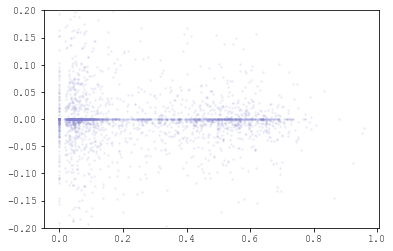

In [95]:
# ppt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(coop_levels[::500], civ_diffs[::500], color=med, alpha=0.1, s=10, marker=".", zorder=3)
ax.set_ylim(bottom=-0.2, top=0.2)

for i, (mean, se) in enumerate(zip(civ_diff_means, civ_diff_ses)):
    ax.plot([i/split, (i + 1)/split], [mean, mean], color=light, zorder=5)
    ax.plot([(i + 0.5)/split, (i + 0.5)/split], [mean - 3.291*se, mean + 3.291*se], color='black', zorder=6)

ax.set_title("Average NI change by cooperation level")
ax.set_xlabel("Cooperation level")
ax.set_ylabel("Change in NI frequency")

format_grid(ax, label="")

fig.savefig("figures/conscience-change.svg")

### Birth rates, death rates, population

In [ ]:
# birth rates
fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(1, 1, 1)

probs = [birth_rate[i/10]["kids_born"]/birth_rate[i/10]["total_rounds"] for i in range(11)]
errors = [math.sqrt(probs[i]*(1 - probs[i])/birth_rate[i/10]["total_rounds"])*3.291 for i in range(11)]
        
X_axis = np.arange(11) / 10

ax.bar(X_axis, probs, yerr=errors, color=turq, width =0.09, zorder=3)

ax.set_xticks(X_axis)

ax.set_title("Birth rate vs. cooperation level")
ax.set_xlabel("Cooperation level")
ax.set_ylabel("Birth rate")

format_grid(ax, label="(A)")

fig.savefig("figures/birth_rate.png", bbox_inches="tight")

# death rates
fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(1, 1, 1)

probs = [death_rate[i/10]["died"]/(death_rate[i/10]["survived"] + death_rate[i/10]["died"]) for i in range(11)]
errors = [math.sqrt(probs[i]*(1 - probs[i])/(death_rate[i/10]["survived"] + death_rate[i/10]["died"]))*3.291 for i in range(11)]
    
X_axis = np.arange(11) / 10

ax.bar(X_axis, probs, yerr=errors, color=red, width =0.09, zorder=3)

ax.set_xticks(X_axis)

ax.set_title("Death rate vs cooperation level")
ax.set_xlabel("Cooperation level")
ax.set_ylabel("Death rate")

format_grid(ax, label="(B)")

fig.savefig("figures/death_rate.png", bbox_inches="tight")

# population
fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(1, 1, 1)

pops = [sum(population_dict[i/10])/len(population_dict[i/10]) for i in range(11)]
errors = [3.291*math.sqrt(np.var(population_dict[i/10])/len(population_dict[i/10])) for i in range(11)]
print(errors)
X_axis = np.arange(11) / 10

ax.bar(X_axis, pops, yerr=errors, color=med, width =0.09, zorder=3)

ax.set_xticks(X_axis)

ax.set_title("Average population vs cooperation level")
ax.set_xlabel("Cooperation level")
ax.set_ylabel("Group population")

format_grid(ax, label="(C)")

fig.savefig("figures/population.png", bbox_inches="tight")

In [ ]:
"""

"""
def make_lag_lists(lst, lst2=None, lags=[0, 1]):
    highest_lag = max(lags)
    
    lds = {}
    
    if lst2 is not None:
        assert len(lst) == len(lst2)
    
    for lag in lags:
        lag_list = splice(lst, lag, highest_lag)
        lds[str(lag) + "_self"] = lag_list
        
        if lst2 is not None:
            lag_list = splice(lst2, lag, highest_lag)
            lds[str(lag) + "_other"] = lag_list
    
    return lds

def splice(lst, lag, highest_lag):
    return lst[highest_lag - lag : len(lst) - lag]
    

def make_big_lag_list(lag_list_of_dicts):
    lags = list(lag_list_of_dicts[0].keys())
    mama_dict = {lag: [] for lag in lags}
    
    # append lists in each lag dict to the mama dict
    for lag_dict in lag_list_of_dicts:
        for lag in lags:
            mama_dict[lag] += lag_dict[lag]
    
    return mama_dict

def get_index_in_coop_sequence(i, coop_sequence, max_lag):
    acc = 0
    for j, lst in enumerate(coop_sequence):
        old_acc = acc
        acc += (len(lst) - max_lag)
        if i < acc:
            return j, i - old_acc, (len(lst) - max_lag)

def make_full_lag_list_from_coop_sequence(sequence, other_sequence=None, lags=[0, 1]):
    lag_list_of_dicts = []

    for i, lst in enumerate(sequence):
        other_lst = None if other_sequence is None else other_sequence[i]
        lds = make_lag_lists(lst, lst2=other_lst, lags=lags)
        lag_list_of_dicts.append(lds)

    full_lag_dict = make_big_lag_list(lag_list_of_dicts)
    
    df = pd.DataFrame(full_lag_dict)
    
    return df

### Code for gathering average lifespan, group size, and number of groups in the spatial simulation

In [ ]:
# gathering parameters so that group sizes, lifetime migration rates, etc. are comparable across simulations

# single file open
f = open("spatial_data/3.25_conscience/deet_stats (1).json")
data = json.load(f)

# get average number of groups, average lifespan, and average population per group
sum_of_groups = 0
sum_of_average_sizes = 0
sum_of_lifespans = 0

for year in range(600, 1000):
    year_string = str(year)
    sum_of_groups += data[year_string]["g"]
    sum_of_lifespans += data[year_string]["span"]
    
    # first adds up the population of each group, then averages it for the year, then adds
    sum_of_sizes = 0
    for group in data[year_string]["groups"].values():
        size = group["civ"]["pop"] + group["sel"]["pop"] + group["sta"]["pop"]
        sum_of_sizes += size
    
    avg_size = sum_of_sizes/data[year_string]["g"]
    sum_of_average_sizes += avg_size

avg_g = sum_of_groups/400
avg_lifespan = sum_of_lifespans/400
avg_group_size = sum_of_average_sizes/400

print("no of groups:", avg_g, "lifespan:", avg_lifespan, "group_size:", avg_group_size)

In [ ]:
def compare_decays(const1, coeff1, const2, coeff2):
    counter_1 = count_decay(const1, coeff1)
    counter_2 = count_decay(const2, coeff2)
    
    print(counter_1, counter_2)
    

def count_decay(const, coeff):
    counter = 0
    var = 1
    while var > 0.5:
        var = coeff * var + const
        counter += 1
    
    return counter

0.0207
0.0124
compare_decays(0, 0.9225, 0, 0.9518)

In [ ]:
fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    bp_datas = [[exp_trough_lengths, con_trough_lengths], [exp_spike_lengths, con_spike_lengths]]
    for i, bp_data in enumerate(bp_datas):
        bp = ax.boxplot(bp_data,
                    positions=[i * 3, i * 3 + 1],
                    patch_artist=True,
                   notch=True,
                    showfliers=False, showmeans=True, meanprops=meanprops, medianprops=medianprops, flierprops=flierprops)

        set_box_colors(bp, color_range=[red, turq])

    ax.legend([bp["boxes"][0], bp["boxes"][1]], ['No norm internalizers', 'With norm internalizers'], loc='lower right')

    ax.set_xticks([0.5, 3.5])
    ax.set_xticklabels(["Troughs", "Peaks"])
    ax.set_ylabel("Cooperation fraction")
    ax.set_title("Cooperation fraction vs. benefit to cost", y=1.02)
    ax.set_xlabel("Benefit to cost")
    format_grid(ax, label="(B)")

In [ ]:
ind = 5

coop_levels = smoother(spatial_data_dict[0.5][0][65]["coop_levels"][ind], window=50)
nc_coop_levels = smoother(spatial_data_dict[0.5][0][65]["nc_coop_levels"][ind], window=50)
civ_coop_levels = smoother(interpolate(spatial_data_dict[0][0.02][65]["civ_coop_levels"][ind]), window=50)

nc_coop_diffs = smoother(np.diff(nc_coop_levels), window=25)
civ_coop_diffs = smoother(np.diff(civ_coop_levels), window=25)


spikes, max_spike_length, avg_spike_length = find_spikes(coop_levels, min_spike_length=100)
print(max_spike_length, avg_spike_length)

tot_spike_arr, tot_avg_spike = calc_average_spike(coop_levels, spikes, 200)
nc_spike_arr, nc_avg_spike = calc_average_spike(nc_coop_levels, spikes, 200)
civ_spike_arr, civ_avg_spike = calc_average_spike(civ_coop_levels, spikes, 200)
civ_diff_arr, civ_diff_avg = calc_average_spike(civ_coop_diffs, spikes, 200)
nc_diff_arr, nc_diff_avg = calc_average_spike(nc_coop_diffs, spikes, 200)

tot_drop_arr, tot_avg_drop = calc_average_drop(coop_levels, spikes, 200)
nc_drop_arr, nc_avg_drop = calc_average_drop(nc_coop_levels, spikes, 200)
civ_drop_arr, civ_avg_drop = calc_average_drop(civ_coop_levels, spikes, 200)

fig1, ax1 = plt.subplots(1)
fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)

coop_mean = sum(coop_levels)/len(coop_levels)

ax1.hlines(y=coop_mean, xmin=0, xmax=len(tot_avg_spike), color=dark)
ax1.plot(range(len(tot_avg_spike)), civ_avg_spike, color=turq)
ax1.plot(range(len(tot_avg_spike)), tot_avg_spike, color=med)
ax1.plot(range(len(tot_avg_spike)), nc_avg_spike, color=red)

ax2.plot(range(len(tot_avg_spike)), civ_diff_avg, color=turq)
ax2.plot(range(len(tot_avg_spike)), nc_diff_avg, color=red)

ax3.hlines(y=coop_mean, xmin=0, xmax=len(tot_avg_spike), color=dark)
ax3.plot(range(len(tot_avg_drop)), civ_avg_drop, color=turq)
ax3.plot(range(len(tot_avg_spike)), tot_avg_drop, color=med)
ax3.plot(range(len(tot_avg_spike)), nc_avg_drop, color=red)

In [ ]:
# make lag lists for benefit = 65, mig = 0.5, spatial
e_coop_sequence = [coop_levels for coop_levels in spatial_data_dict[0][0.02][65]["coop_levels"]]
e_civ_pop_sequence = [civ_pop for civ_pop in spatial_data_dict[0][0.02][65]["civ_levels"]]

e_civ_pop_sequence_diff = [list(np.diff(civ_pop)) for civ_pop in e_civ_pop_sequence]
e_coop_sequence_shortened = [coop_levels[1:] for coop_levels in e_coop_sequence]

print([len(lst) for lst in e_civ_pop_sequence_diff])
print([len(lst) for lst in e_coop_sequence_shortened])

df_coop_pop = make_full_lag_list_from_coop_sequence(e_civ_pop_sequence, e_coop_sequence, lags=[0, 50, 100])
df_coop_pop

In [ ]:
# self is civic pop, other is coop level
x = df_coop_pop[['50_self', '100_self', '50_other', '100_other']]
y = df_coop_pop['0_self']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

In [ ]:
e_nc_coop_sequence = [nc_coop for nc_coop in spatial_data_dict[0.5][0.02][65]["nc_coop_levels"]]
e_civ_coop_sequence = [interpolate(civ_coop) for civ_coop in spatial_data_dict[0.5][0.02][65]["civ_coop_levels"]]

df_nc_civ = make_full_lag_list_from_coop_sequence(e_nc_coop_sequence, e_civ_coop_sequence, lags=[0, 1, 2])
df_nc_civ

In [ ]:
x = df_nc_civ[['1_self', '2_self', '1_other', '2_other']]
y = df_nc_civ['0_other']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

In [ ]:
e_civ_pop_sequence = [nc_coop for nc_coop in spatial_data_dict[0.5][0.02][65]["nc_coop_levels"]]
e_civ_coop_sequence = [interpolate(civ_coop) for civ_coop in spatial_data_dict[0.5][0.02][65]["civ_coop_levels"]]

df_civ_pop_coop = make_full_lag_list_from_coop_sequence(e_civ_pop_sequence, e_civ_coop_sequence, lags=[0, 200, 400])
df_civ_pop_coop

In [ ]:
x = df_civ_pop_coop[['200_self', '400_self', '200_other', '400_other']]
y = df_civ_pop_coop['0_other']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

In [ ]:
coop_con_fig = plt.figure(figsize=(6.4,3))
nc_coop_con_fig = plt.figure(figsize=(6.4, 3))
ratio_fig = plt.figure(figsize=(6.4, 2))

coop_con_ax = coop_con_fig.add_subplot(1, 1, 1)
nc_coop_con_ax = nc_coop_con_fig.add_subplot(1, 1, 1)
ratio_ax = ratio_fig.add_subplot(1, 1, 1)

# figure for coop vs conscience prevalence
coop_con_ax.scatter(civ_pcts[::300], coop_levels_long[::300], color=turq, alpha=0.1, s=10, marker=".", zorder=3)
for i, (mean, se) in enumerate(zip(coop_means, coop_ses)):
    coop_con_ax.plot([i/10, (i + 1)/10], [mean, mean], color=dark, zorder=5)
    coop_con_ax.plot([(i + 0.5)/10, (i + 0.5)/10], [mean - 3.291*se, mean + 3.291*se], color='black', zorder=5)

coop_con_ax.set_title("Cooperation level vs.\nprevalence of norm internalization")
coop_con_ax.set_ylabel("Cooperation level")

format_grid(coop_con_ax, label="(A)")

# figure for non-civic coop vs conscience prevalence
nc_coop_con_ax.scatter(civ_pcts[::200], nc_coop_levels_long[::200], color=red, alpha=0.1, s=0.1, zorder=3)

for i, (mean, se) in enumerate(zip(nc_coop_means, nc_coop_ses)):
    nc_coop_con_ax.plot([i/10, (i + 1)/10], [mean, mean], color=dark, zorder=5)
    nc_coop_con_ax.plot([(i + 0.5)/10, (i + 0.5)/10], [mean - 3.291*se, mean + 3.291*se], color='black', zorder=5)

nc_coop_con_ax.set_title("Non-conscience cooperation level vs.\nprevalence of norm internalization")
nc_coop_con_ax.set_xlabel("Prevalence of conscience")
nc_coop_con_ax.set_ylabel("Cooperation level")
format_grid(nc_coop_con_ax, label="(B)")

# figure for 
errors = [ratio_se*3.291 for ratio_se in ratio_ses]
X_axis = np.arange(10) / 10
ratio_ax.bar(X_axis, ratios, yerr=errors, color=med, width =0.095, zorder=3)
ratio_ax.set_xticks(X_axis)
ratio_ax.set_title("Groups <80% cooperation with <20% cooperation")
ratio_ax.set_ylabel("Fract with <20% cooperation")
ratio_ax.set_xlabel("Prevalence of conscience")

format_grid(ratio_ax, "(C)")

coop_con_fig.savefig("figures/coop_by_conscience_prev.svg")
nc_coop_con_fig.savefig("figures/nc_coop_by_conscience_prev.svg")
ratio_fig.savefig("figures/extremity_of_coop.svg", bbox_inches="tight")

In [ ]:
# for powerpoint
# high-civic graph
print(coop_levels_pres_maj[0:20])
print(len(coop_levels_pres_maj))
print(coop_levels_futu_maj[0:20])
print(len(coop_levels_futu_maj))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(coop_levels_pres_maj[::100], coop_levels_futu_maj[::100], color=turq, alpha=0.1, s=10, zorder=3)
ax.plot(coop_p_maj_arr, coop_p_maj_arr, color=med, zorder=4, linewidth=2)
ax.plot(coop_p_maj_arr, coop_f_pred_maj, color=dark, zorder=5, linewidth=2)

ax.set_title("High-consience groups: \n Lagged (5 rounds) vs. present cooperation levels")
ax.set_xlabel("Lagged fract of cooperators")
ax.set_ylabel("Fract of cooperators")

format_grid(ax, label="(A)")

fig.savefig("figures/lagged-vs-present-coop-high-conscience.svg")

# low civic graph
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(coop_levels_pres_min[::500], coop_levels_futu_min[::500], s=10, alpha=0.1, color=red, zorder=3)

ax.plot(coop_p_min_arr, coop_p_min_arr, color=med, zorder=4, linewidth=2)
ax.plot(coop_p_min_arr, coop_f_min_pred, color=dark, zorder=5, linewidth=2)

ax.set_title("Low-conscience groups: \n Lagged (5 rounds) vs. present cooperation levels")
ax.set_xlabel("Lagged fract of cooperators")
ax.set_ylabel("Fract of cooperators")

format_grid(ax, label="(B)")

fig.savefig("figures/lagged-vs-present-coop-low-conscience.svg", bbox_inches="tight")

In [ ]:
# dictionary that stores the highly cooperative groups and the level of civic learners that were present
# when they started being highly cooperative
high_coop_dict = {} 

# Tally up the number of rounds that are highly cooperative that were instigated 
# by a high civic population vs low civic population
high_civic_instigated_coop_rounds = 0
low_civic_instigated_coop_rounds = 0

# Tally up the number of rounds that are highly cooperative that have high numbers of civic learners
high_civic_coop_rounds = 0
low_civic_coop_rounds = 0

total_coop_rounds = 0

high_civic_rounds = 0
low_civic_rounds = 0

for deet_data in spatial_deet_datas:
    for year, dat in deet_data.items():
        for group, little_dat in dat['groups'].items():

            # calculate the cooperation level
            pop, _ = population(little_dat)
            civ_pct = little_dat["civ"]["pop"]/pop
            coop_pct = total_coop_level(little_dat)[0]/pop

            high_civic_rounds += (civ_pct > 0.3)
            low_civic_rounds += (civ_pct <= 0.3)

            # if it's under 50% for the first time, pop its value 
            if coop_pct <= 0.5 and group in high_coop_dict:
                high_coop_dict.pop(group)


            if coop_pct > 0.5:

                # if it's over 50% for the first time, save its threshold value
                if group not in high_coop_dict:
                    high_coop_dict[group] = civ_pct

                # increment the correct counters 
                high_civic_instigated_coop_rounds += (high_coop_dict[group] > 0.3)
                low_civic_instigated_coop_rounds += (high_coop_dict[group] <= 0.3)
                total_coop_rounds += 1


                high_civic_coop_rounds += (civ_pct > 0.3)
                low_civic_coop_rounds += (civ_pct <= 0.3)


print("Number of cooperative rounds INSTIGATED by high civic:", high_civic_instigated_coop_rounds)
print("Ratio of cooperative rounds instigated by high civic / high civic rounds:", high_civic_instigated_coop_rounds/high_civic_rounds)

print("Number of cooperative rounds INSTIGATED by low civic:", low_civic_instigated_coop_rounds)
print("Ratio of cooperative rounds instigated by low civic / low civic rounds:", low_civic_instigated_coop_rounds/low_civic_rounds)

print("-------------")

print("Number of cooperative rounds with high civic:", high_civic_coop_rounds)
print("Percentage of high civic rounds that are cooperative:", high_civic_coop_rounds/high_civic_rounds)

print("Number of cooperative rounds with low civic:", low_civic_coop_rounds)
print("Percentage of low civic rounds that are cooperative:", low_civic_coop_rounds/low_civic_rounds)

In [ ]:
data = [low_civic_instigated_coop_rounds/low_civic_rounds, high_civic_instigated_coop_rounds/high_civic_rounds]

fig, ax = plt.subplots()

X_axis = np.arange(2) + 0.5
ax.set_title("Ratio of number of cooperative rounds \n instigated by low/high conscience populations \n to the number of low/high conscience rounds")
ax.bar(X_axis, data, width=0.95, color=med, zorder=3)
ax.set_xticks(X_axis)
ax.set_ylabel("Ratio of cooperative rounds instigated")
ax.set_xticklabels(["Low conscience", "High conscience"])
ax.plot([0, 2], [1, 1], color=turq, linestyle="dashed", zorder=5)


format_grid(ax, label="")
fig.savefig("figures/instigation_of_coop.png")
fig.savefig("figures/instigation_of_coop.svg")

# Pinhead Model

## Collect data

In [ ]:
benefits = [3.25, 3.5, 3.75, 4, 4.25]
distribs = [(0.01, 0.01), (0.02, 0.00), (0.00, 0.02)]
con = 1/13

transition_dict = {
                    distrib: {
                        benefit: defaultdict(lambda: 0) for benefit in benefits
                            } for distrib in distribs   
                  }

old_data = False
pop = 40*80

for benefit in benefits:
    for distrib in distribs:
        print(con, benefit, distrib)
        
        # get file names from the directory
        distrib_name = lookup_distrib_name_pinhead(distrib)
        subdir = f"{benefit:.2f}_{distrib_name}"
        dirname = f"pinhead_data/{subdir}"
        
        if not os.path.isdir(dirname):
            continue

        files = os.listdir(dirname)
        
        # remove annoying files 
        if "Icon\r" in files:
            files.remove("Icon\r")
        if ".DS_Store" in files:
            files.remove(".DS_Store")
        if "desktop.ini" in files:
            files.remove("desktop.ini")
        
        # initialize lists of things to keep track of
        up_transitions = []
        up_transition_times = []
        down_transitions = []
        down_transition_times = []
        end_years = []
        never_counter_up = 0
        never_counter_down = 0

        for file in files:
            
            # load the data
            f = open(f"{dirname}/{file}")
            data = json.load(f)
            params = data.pop("params")
            
            # verify that this data has the correct parameters
            expected_saint = distrib[1]
            expected_citizen = distrib[0]

            assert params["distrib"]["citizen"] == expected_citizen
            assert params["distrib"]["saint"] == expected_saint
            assert params["p_con"] == con
            assert params["benefit"] == benefit
            
            coop_window = [] # levels of cooperation for the chosen window
            coop_mean = 0 # mean cooperation in the window
            transitions = {"up": [], "down": []} # when the simulation transitions from low to high coop
            last_low_coop = 0 # the last time coop was low
            last_high_coop = 0 # the last time coop was high

            for year, dat in data.items():
                cooperators, noncivic_cooperators = total_coop_level(dat)
                coop_level = cooperators/pop

                coop_window.append(coop_level)

                if len(coop_window) > 50:
                    coop_window.pop(0)

                prev_coop_mean = coop_mean
                coop_mean = sum(coop_window)/len(coop_window)
                
                # keep track of the last time cooperation was low/high
                if coop_mean < 0.15:
                    last_low_coop = int(year)
                elif coop_mean > 0.9:
                    last_high_coop = int(year)
                
                # keep track of when cooperation exceeds high or low thresholds
                if prev_coop_mean < 0.9 and coop_mean >= 0.9:
                    transitions["up"].append({"start": last_low_coop, "end": int(year)})
                elif prev_coop_mean >= 0.15 and coop_mean < 0.15:
                    transitions["down"].append({"start": last_high_coop, "end": int(year)})


            end_years.append(year)
            
            # store the up and down transitions, in addition to how long they took
            if len(transitions["up"]) > 0:
                trans_end = transitions["up"][0]["end"]
                trans_start = transitions["up"][0]["start"]
                up_transitions.append(trans_end)
                up_transition_times.append(trans_end - trans_start)
            else:
                never_counter_up += 1

            if len(transitions["down"]) > 0:
                trans_end = transitions["down"][0]["end"]
                trans_start = transitions["down"][0]["start"]
                down_transitions.append(trans_end)
                down_transition_times.append(trans_end - trans_start)
            else:
                never_counter_down += 1

        # if we start from common, pay attention to down transitions, otherwise, do the opposite
        if distrib[0] + distrib[1] == 0.98:
            print("starting from common!!")
            transitions = down_transitions
            transition_times = down_transition_times
            never_counter = never_counter_down
        else:
            transitions = up_transitions
            transition_times = up_transition_times
            never_counter = never_counter_up
        
        # save the average round and average time, along with the standard errors
        avg = 50000
        std = 10000
        stderr = 10000
        if len(transitions) > 0:
            avg = sum(transitions)/len(transitions)
            std = math.sqrt(sum([(x - avg)**2 for x in transitions])/(max([len(transitions) - 1, 1])))
            stderr = std / math.sqrt(len(transitions))

        fract = len(transitions)/(len(transitions) + never_counter)

        avg_time = sum(transition_times)/len(transition_times)
        std_time = math.sqrt(sum([(x - avg_time)**2 for x in transition_times])/(max([len(transition_times) - 1, 1])))
        stderr_time = std_time/math.sqrt(len(transition_times))
        
        # store in a dictionary
        transition_dict[distrib][benefit]["data"] = transitions # when all the transitions occurred
        transition_dict[distrib][benefit]["times"] = transition_times # how long all the transitions occurred
        transition_dict[distrib][benefit]["n"] = len(transitions) + never_counter 
        
        # transition round stats
        transition_dict[distrib][benefit]["avg"] = avg # average round of transition
        transition_dict[distrib][benefit]["std"] = std # std for round of transition
        transition_dict[distrib][benefit]["stderr"] = stderr # stderr for round of transition
        
        # transition time stats 
        transition_dict[distrib][benefit]["avg_time"] = avg_time
        transition_dict[distrib][benefit]["std_time"] = std_time
        transition_dict[distrib][benefit]["stderr_time"] = stderr_time
        
        # fraction stats
        transition_dict[distrib][benefit]["fract"] = fract
        transition_dict[distrib][benefit]["fract_stderr"] = math.sqrt(fract*(1 - fract)/(len(up_transitions) + never_counter))


        print(len(transitions), len(transitions) + never_counter)
        print("avg", avg, "stderr", stderr, "fract", fract)
        print("avg_time", avg_time, "stderr_time", stderr_time)
        print("-------------------")
    print("-------------------------------------------------")

## Calculate average time to high cooperation for each level of benefit

In [ ]:
# average the time for each of the three conditions
average_across_distribs = {benefit: sum([transition_dict[distrib][benefit]["avg"]/3 for distrib in distribs]) 
                           for benefit in benefits}

# the variance of the sum of RVs is the sum of the variances. Then divide by 9 because of the constant 1/3
sd_across_distribs = {benefit: math.sqrt(sum([transition_dict[distrib][benefit]["stderr"]**2/9 for distrib in distribs])) 
                      for benefit in benefits}

print("Mean time to achieve high cooperation:")
print(average_across_distribs)
print("Standard error time to achieve high cooperation:")
print(sd_across_distribs)
print("95 pct confidence intervals")

# t-test with two degrees of freedom
print({benefit: [average_across_distribs[benefit] - 4.303 * x, average_across_distribs[benefit] + 4.303 * x] 
       for benefit, x in sd_across_distribs.items()})

## Calculate the significance of differences between (1) fraction of high coop and (2) time for high coop 

In [ ]:
benefits = [3.25, 3.5, 3.75, 4, 4.25]
# add correct number of asterisks for significance
sig_labels = []
fract_sig_labels = []
for i, benefit in enumerate(benefits):
    print(benefit)
    # calculate the difference of the times and the standard deviation of the quantity
    diff_time_mean = transition_dict[(0.02, 0.0)][benefit]["avg"] - transition_dict[(0.0, 0.02)][benefit]["avg"]
    diff_time_var =  transition_dict[(0.02, 0.0)][benefit]["stderr"]**2 + transition_dict[(0.0, 0.02)][benefit]["stderr"]**2
    diff_time_std = math.sqrt(diff_time_var)
    
    # get t-score and the p value based on the degrees of freedom
    time_t_score = abs(diff_time_mean/diff_time_std)
    df = min(transition_dict[(0.02, 0.0)][benefit]["n"], transition_dict[(0.0, 0.02)][benefit]["n"]) - 1
    p_value = scipy.stats.t.sf(time_t_score, df=df)*2

    # calculate z confidence intervals (quick and dirty check)
    diff_time_95_conf = [diff_time_mean - diff_time_std *1.96, diff_time_mean + diff_time_std *1.96]
    diff_time_98_conf = [diff_time_mean - diff_time_std *2.33, diff_time_mean + diff_time_std *2.33]
    diff_time_99_conf = [diff_time_mean - diff_time_std *2.58, diff_time_mean + diff_time_std *2.58]
    print("level statistics")
    print(f"The mean difference is {round(diff_time_mean, 2)}.")
    print(f"The standard deviation is {diff_time_std}") 
    print(f"The 0.98 confidence interval for the difference of benefit {benefit} is from {round(diff_time_98_conf[0], 2)} to {round(diff_time_98_conf[1], 2)}")
    print(f"The 0.99 confidence interval for the difference of benefit {benefit} is from {round(diff_time_99_conf[0], 2)} to {round(diff_time_99_conf[1], 2)}")
    print("-------")
    # calculate the number of stars and append them to the significance list
    if p_value < 0.01:
        stars = "**"
    elif p_value < 0.02:
        stars = "*"
    else:
        stars = ""
        
    sig_labels.append(stars)
    
    # calculate the difference in the fraction of runs that converged
    diff_fract_mean = transition_dict[(0.02, 0.0)][benefit]["fract"] - transition_dict[(0.0, 0.02)][benefit]["fract"]
    diff_fract_var =  transition_dict[(0.02, 0.0)][benefit]["fract_stderr"]**2 + transition_dict[(0.0, 0.02)][benefit]["fract_stderr"]**2
    diff_fract_std = math.sqrt(diff_fract_var)
    
    # use this thing to get the z score 
    # https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other
    n1 = transition_dict[(0.02, 0.0)][benefit]["n"]
    n2 = transition_dict[(0.0, 0.02)][benefit]["n"]
    p1 = transition_dict[(0.02, 0.0)][benefit]["fract"]
    p2 = transition_dict[(0.0, 0.02)][benefit]["fract"]
    p_hat = (p1*n1 + p2*n2)/(n1 + n2)
    
    if p_hat < 1:
        z_score = (p1 - p2)/(p_hat*(1 - p_hat)*(1/n1 + 1/n2))
    else:
        z_score = 5
        
    p_value = scipy.stats.norm.sf(abs(z_score))
    
    
    # confidence intervals for sanity
    diff_fract_95_conf = [diff_fract_mean - diff_fract_std *1.96, diff_fract_mean + diff_fract_std *1.96]  
    diff_fract_98_conf = [diff_fract_mean - diff_fract_std *2.33, diff_fract_mean + diff_fract_std *2.33]
    diff_fract_99_conf = [diff_fract_mean - diff_fract_std *2.58, diff_fract_mean + diff_fract_std *2.58]
    print("fraction statistics")
    print(f"The mean difference is {round(diff_fract_mean, 2)}.")
    print(f"The standard deviation is {diff_fract_std}") 
    print(f"The 0.98 confidence interval for the difference of benefit {benefit} is from {round(diff_fract_98_conf[0], 2)} to {round(diff_fract_98_conf[1], 2)}")
    print(f"The 0.99 confidence interval for the difference of benefit {benefit} is from {round(diff_fract_99_conf[0], 2)} to {round(diff_fract_99_conf[1], 2)}")
    print("-----------------------")
    stars = ""
    # calculate the number of stars and append them to the significance list
    if p_value < 0.001:
        stars = "***"
    elif p_value < 0.01:
        stars = "**"
    elif p_value < 0.02:
        stars = "*"
    else:
        stars = ""

    fract_sig_labels.append(stars)

## create the figures 

In [ ]:
distribs = [(0.0, 0.02), (0.01, 0.01), (0.02, 0.00)]

benefits = [3.25, 3.5, 3.75, 4, 4.25]

fig = plt.figure(figsize=(8, 7))
gs = fig.add_gridspec(8, 6)

trans_time_ax = fig.add_subplot(gs[0:2, 1:5])
fraction_ax = fig.add_subplot(gs[2:6, 0:1])
trans_round_ax = fig.add_subplot(gs[2:6,1:5])
trans_time_abs_ax = fig.add_subplot(gs[6:8,1:5])

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=13) 

X_axis = np.arange(len(benefits))

# transition time bar chart
barchart_levels_trans_times = defaultdict(list)
barchart_errors_trans_times = defaultdict(list)

for distrib in distribs:
    for benefit in benefits:
        t_value = scipy.stats.t.ppf(0.975, transition_dict[distrib][benefit]["n"] - 1, loc = 0, scale = 1)
        barchart_levels_trans_times[distrib].append(transition_dict[distrib][benefit]["avg_time"])
        barchart_errors_trans_times[distrib].append(transition_dict[distrib][benefit]["stderr_time"]*t_value)

    
trans_time_ax.bar(X_axis - 0.2, barchart_levels_trans_times[(0.0, 0.02)][0], yerr=barchart_errors_trans_times[(0.0, 0.02)][0], color=red, width =0.15, label="No conscience", zorder=3)
trans_time_ax.bar(X_axis, barchart_levels_trans_times[(0.01, 0.01)][0], yerr=barchart_errors_trans_times[(0.01, 0.01)][0], color=dark, width =0.15, label="Mix", zorder=3)
trans_time_ax.bar(X_axis + 0.2, barchart_levels_trans_times[(0.02, 0.0)][0], yerr=barchart_errors_trans_times[(0.02, 0.0)][0], color=turq, width =0.15, label="Conscience", zorder=3)
trans_time_ax.set_xticks(X_axis)
trans_time_ax.set_xticklabels([benefit for benefit in benefits])

trans_time_ax.legend()
trans_time_ax.set_title("Transition time\n(Time spent between low and high cooperation)")
trans_time_ax.set_ylabel("Rounds")
format_grid(trans_time_ax, label="(A)")


# fraction bar chart
barchart_levels_fract = defaultdict(list)
barchart_errors_fract = defaultdict(list)

for distrib in distribs:
    for benefit in benefits:
        t_value = scipy.stats.t.ppf(0.975, transition_dict[distrib][benefit]["n"] - 1, loc = 0, scale = 1)
        barchart_levels_fract[distrib].append(transition_dict[distrib][benefit]["fract"])
        barchart_errors_fract[distrib].append(transition_dict[distrib][benefit]["fract_stderr"]*t_value)

fraction_ax.bar([-0.2], barchart_levels_fract[(0.0, 0.02)][0], yerr=barchart_errors_fract[(0.0, 0.02)][0], color=red, width =0.15, zorder=3)
fraction_ax.bar([0], barchart_levels_fract[(0.01, 0.01)][0], yerr=barchart_errors_fract[(0.01, 0.01)][0], color=dark, width =0.15, zorder=3)
fraction_ax.bar([0.2], barchart_levels_fract[(0.02, 0.0)][0], yerr=barchart_errors_fract[(0.02, 0.0)][0], color=turq, width =0.15, zorder=3)
fraction_ax.set_xticks([0])
fraction_ax.set_xticklabels([benefits[0]])


fraction_ax.set_title("Fraction of time high\ncoop is reached", y=1.02)
fraction_ax.set_ylabel("Fraction")
fraction_ax.set_yticks([0.3, 0.6, 0.9])
fraction_ax.set_ylim(bottom=0, top=1)
fraction_ax.text(0.2, barchart_levels_fract[(0.02, 0.0)][0] + barchart_errors_fract[(0.02, 0.0)][0] + 0.02, 
                 fract_sig_labels[0], ha="center", va="center")
format_grid(fraction_ax, label="(B)")


# number of rounds box plot

for i, benefit in enumerate(benefits):
    bp = trans_round_ax.boxplot([np.array(transition_dict[distrib][benefit]["data"])/average_across_distribs[benefit] for distrib in distribs],
                positions=[i * 4, i * 4 + 1, i * 4 + 2],
                patch_artist=True,
               notch=True, showmeans=True, meanprops=meanprops, medianprops=medianprops, showfliers=False)

    trans_round_ax.text(i * 4 + 2, bp["whiskers"][5].get_data()[1][1] + 0.05, sig_labels[i], ha="center", va="center")
    set_box_colors(bp)

trans_round_ax.set_xticks([1, 5, 9, 13, 17])
trans_round_ax.set_yticks([i/2 for i in range(5)])
trans_round_ax.set_xticklabels([benefit for benefit in benefits])
trans_round_ax.set_ylim(bottom=0, top=2.1)
trans_round_ax.set_title("Time from start relative to average\n to achieve high cooperation", y=1.02)

trans_round_ax.set_ylabel("Ratio relative to average")

format_grid(trans_round_ax, label="(C)")


trans_time_abs_ax.bar(X_axis, [rounds for ben, rounds in average_across_distribs.items()], yerr=barchart_errors_trans_times[(0.0, 0.02)][0], color=med, width=0.45, zorder=3)
trans_time_abs_ax.set_xticks(X_axis)
trans_time_abs_ax.set_xticklabels([benefit for benefit in benefits])
trans_time_abs_ax.set_xlabel("Benefit to cost")
trans_time_abs_ax.set_ylabel("Rounds")
trans_time_abs_ax.set_title("Average time from start (across conditions) \n to achieve high cooperation", y=1.02)

format_grid(trans_time_abs_ax, label="(D)")


fig.savefig(f"figures/pinhead_model_stats.png", bbox_inches="tight")

In [ ]:
p_exp_length_dist, _ = length_prob_distros([trough["length"] for trough in flatten(p_exp_trough_props)], bins=None, bin_size=100)
p_con_length_dist, _ = length_prob_distros([trough["length"] for trough in flatten(p_con_trough_props)], bins=None, bin_size=100)

longer_dim = max(len(p_exp_length_dist), len(p_con_length_dist))

p_exp_length_dist = extend_dim((longer_dim), p_exp_length_dist)
p_con_length_dist = extend_dim((longer_dim), p_con_length_dist)


print(p_exp_length_dist) #[4:].sum())
print(p_con_length_dist) #[4:].sum())
fig, ax = plt.subplots(1)

ax.plot([i * 500 for i in range(len(p_exp_length_dist))], p_exp_length_dist)
ax.plot([i * 500 for i in range(len(p_con_length_dist))], p_con_length_dist)

In [ ]:
coop_p_min_arr = np.array(coop_levels_pres_min).reshape(-1, 1)
coop_f_min_arr = np.array(coop_levels_futu_min).reshape(-1, 1)
coop_p_min_arr_const = sm.add_constant(coop_p_min_arr)

olsmod = sm.OLS(coop_f_min_arr, coop_p_min_arr_const)
olsres = olsmod.fit()
print(olsres.summary())

coop_f_min_pred = olsres.predict(coop_p_min_arr_const)

In [ ]:
matrix_low = np.array([[0, 0], [0, 0]])

for pres, futu in zip(coop_levels_pres_min, coop_levels_futu_min):
    increment = np.array([[pres <= cutoff and futu <= cutoff, pres <= cutoff and futu > cutoff], [pres > cutoff and futu <= cutoff, pres > cutoff and futu > cutoff]])
        
    matrix_low += increment

print(matrix_low)
pct_matrix_low = matrix_low/matrix_low.sum(axis=1).reshape(2, 1)
print(pct_matrix_low)
print(pct_matrix_low)

print("LOW CIVIC GROUPS")
print("Low coop groups that languished:", matrix_low[0, 0]/(matrix_low[0, 0] + matrix_low[0, 1]))
print("Low coop groups that rose:", matrix_low[0, 1]/(matrix_low[0, 0] + matrix_low[0, 1]))
print("High coop groups that fell:", matrix_low[1, 0]/(matrix_low[1, 0] + matrix_low[1, 1]))
print("High coop groups that maintained:", matrix_low[1, 1]/(matrix_low[1, 0] + matrix_low[1, 1]))

sd_matrix_low = np.sqrt(pct_matrix_low*(1 - pct_matrix_low)/matrix_low.sum(axis=1).reshape(2, 1))
conf_matrix_low = sd_matrix_low*3.291
print(conf_matrix_low)

In [ ]:
# plot_civ_nc_time_series(ind, data_dict, benefit, mig, run_length=20050, window=500)
plot_civ_nc_time_series(6, "spatial", spatial_data_dict, 60, 0.5)

In [ ]:
"""
    print(char_trans)
    
    tot_spike_count, civ_start_count, civ_end_count, nc_start_count, nc_end_count, spike_prop_lists = compare_civ_nc_spikes(spike_lists, civ_spike_lists, nc_spike_lists)
    trans_mat = construct_markov_process(spike_lists, spike_prop_lists)
    lengths, counts = get_avg_length_of_each_type(spike_prop_lists)
    print(lengths, counts, lengths / counts)
    
    print(trans_mat)
    
    _, tot_avg_spike, _, tot_avg_drop = calc_average_spike_drop_across_runs(coop_lists, spike_lists, 200, extension=100)
    _, nc_avg_spike, _, nc_avg_drop = calc_average_spike_drop_across_runs(nc_coop_lists, spike_lists, 200, extension=100)
    _, civ_avg_spike, _, civ_avg_drop = calc_average_spike_drop_across_runs(civ_coop_lists, spike_lists, 200, extension=100)
    
    fig1, ax1 = plt.subplots(1)
    fig2, ax2 = plt.subplots(1)
    
    coop_mean = sum([elt for coop_list in coop_lists for elt in coop_list]) / sum([len(coop_list) for coop_list in coop_lists])
    ax1.hlines(y=coop_mean, xmin=0, xmax=len(tot_avg_spike), color=dark)
    ax1.plot(range(len(tot_avg_spike)), civ_avg_spike, color=turq)
    ax1.plot(range(len(tot_avg_spike)), tot_avg_spike, color=med)
    ax1.plot(range(len(tot_avg_spike)), nc_avg_spike, color=red)
    
    ax2.hlines(y=coop_mean, xmin=0, xmax=len(tot_avg_spike), color=dark)
    ax2.plot(range(len(tot_avg_drop)), civ_avg_drop, color=turq)
    ax2.plot(range(len(tot_avg_drop)), tot_avg_drop, color=med)
    ax2.plot(range(len(tot_avg_drop)), nc_avg_drop, color=red)
    
    fig, ((hist1, hist2), (hist3, hist4), (hist5, hist6)) = plt.subplots(nrows=3, ncols=2)

    
    hist1.hist([prop["avg_val"] for prop in spike_props_civ])
    print("average civic coop val on peak", calc_mean_sd_se([prop["avg_val"] for prop in spike_props_civ]))
    
    hist3.hist([prop["avg_val"] for prop in trough_props_civ])
    print("average civic coop val on trough", calc_mean_sd_se([prop["avg_val"] for prop in trough_props_civ]))
    
    hist5.hist([prop["peak_index"] for prop in spike_props_civ])
    print("average civic peak index", calc_mean_sd_se([prop["peak_index"] for prop in spike_props_civ]))
    
    hist2.hist([prop["avg_val"] for prop in spike_props_nc])
    print("average nc coop val on peak", calc_mean_sd_se([prop["avg_val"] for prop in spike_props_nc]))
    
    hist4.hist([prop["avg_val"] for prop in trough_props_nc])
    print("average nc coop val on trough", calc_mean_sd_se([prop["avg_val"] for prop in trough_props_nc]))
    
    hist6.hist([prop["peak_index"] for prop in spike_props_nc])
    print("average nc peak index", calc_mean_sd_se([prop["peak_index"] for prop in spike_props_nc]))
    
    
    # INCLUDE: plot for showing when peaks occur on various runs
    trace_fig, (trace_ax0, trace_ax1) = plt.subplots(nrows=2, ncols=1)
    
    dot_color_dict = {"civciv": turq, "civnci": med, "nciciv": dark, "ncinci": red}
    
    for i, (spike_list, spike_prop_list) in enumerate(zip(spike_lists, spike_prop_lists)):
        for spike, prop in zip(spike_list, spike_prop_list):
            color = civ_nci_dict_lookup(dot_color_dict, prop)
            trace_ax0.plot(spike, [i, i], color=med, zorder=3)
    
    for i, spike_list in enumerate(c_spike_lists):
        for spike in spike_list:
            trace_ax1.plot(spike, [i, i], color=med, zorder=3)
    
    exp_trough_lengths = [prop["length"] for prop in trough_props_tot]
    con_trough_lengths = [prop["length"] for prop in c_trough_props]
    exp_spike_lengths = [prop["length"] for prop in spike_props_tot]
    con_spike_lengths = [prop["length"] for prop in c_spike_props]
    
    print("---\nINCLUDE.")
    print("Noteworthy: the variance of the trough length is much higher. Also, peaks are longer in the control, but var is similar.")
    print("average trough length exp", calc_mean_sd_se(exp_trough_lengths))
    print("average trough length control", calc_mean_sd_se(con_trough_lengths))
    print("average spike length exp", calc_mean_sd_se(exp_spike_lengths))
    print("average spike length control", calc_mean_sd_se(con_spike_lengths))
    print("---")
    
    
    print("average spike value exp", calc_mean_sd_se([prop["avg_val"] for prop in spike_props_tot]))
    print("average spike value control", calc_mean_sd_se([prop["avg_val"] for prop in c_spike_props]))
    
    
    print("average trough value exp", calc_mean_sd_se([prop["avg_val"] for prop in trough_props_tot]))
    print("average trough value control", calc_mean_sd_se([prop["avg_val"] for prop in c_trough_props]))
    print("----")
    print("average spike length civ", calc_mean_sd_se([prop["length"] for prop in civ_spike_props]))
    print("average spike length nc", calc_mean_sd_se([prop["length"] for prop in nc_spike_props]))
    print("average spike value civ", calc_mean_sd_se([prop["avg_val"] for prop in civ_spike_props]))
    print("average spike value nc", calc_mean_sd_se([prop["avg_val"] for prop in nc_spike_props]))
    
    print("average trough length civ", calc_mean_sd_se([prop["length"] for prop in civ_trough_props]))
    print("average trough length nc", calc_mean_sd_se([prop["length"] for prop in nc_trough_props]))
    print("average trough value civ", calc_mean_sd_se([prop["avg_val"] for prop in civ_spike_props]))
    print("average trough value nc", calc_mean_sd_se([prop["avg_val"] for prop in nc_trough_props]))
    
    print([length for length in con_trough_lengths if length > 2000])
    """

In [ ]:

print(row_norm)
G=nx.MultiDiGraph()

G.add_node(0,pos=(0,8))
G.add_node(1,pos=(2,6))
G.add_node(2,pos=(6,6))
G.add_node(3,pos=(2,2))
G.add_node(4,pos=(6,2))



pos=nx.get_node_attributes(G,'pos')

for i, row in enumerate(row_norm):
    for j, elt in enumerate(row):
        if elt > 0.05 and i != j:
            G.add_edge(i,j, weight=(str(round(elt * 100)) + "%"))
            
labels = nx.get_edge_attributes(G,'weight')
labels = {(start, end): labels[(start, end, 0)] for start, end, _ in labels}

In [ ]:
"""
nx.draw_networkx(G, pos, connectionstyle='arc3, rad = 0.1')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.25)
"""
g = pn.Network('500px', '500px', directed=True, notebook=True)
g.add_nodes([0,1,2,3,4], value=[100, 100, 100, 100, 100],
                         title=['', '', '', '',''],
                         x=[-150, -50, -50, 150, 150],
                         y=[-150, -50, 150, -50, 150],
                         label=['0', '1', '2', '3', '4'],
                         color=['#dd4b39', '#dd4b39', '#dd4b39', '#dd4b39', '#dd4b39'])

for n in g.nodes:
    n.update({'physics': False})

for i, row in enumerate(row_norm):
    for j, elt in enumerate(row):
        if elt > 0.05 and i != j:
            weight = round(100 * elt)
            g.add_edge(i, j, weight=weight, label=str(weight))

g.show_buttons()

g.show('nx.html')

In [ ]:
"""
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

for i, benefit in enumerate(benefits):
    bp_data = []
    for distrib in [0.0, 0.02]:
        if distrib == 0.0:
            bp_data.append(data_dict[distrib][benefit]["coop_levels"])
        else:
            bp_data.append(data_dict[distrib][benefit]["nc_coop_levels"])
            bp_data.append(data_dict[distrib][benefit]["coop_levels"])
    
    bp = ax.boxplot(bp_data,
                positions=[i * 4, i * 4 + 1, i * 4 + 2],
                patch_artist=True,
               notch=True,
                showfliers=False, showmeans=True, meanprops=meanprops, medianprops=medianprops, flierprops=flierprops)
    
    ax.text(i * 4 + 1, bp["whiskers"][3].get_data()[1][1] + 0.01, nc_sig_labels[i], ha="center", va="center")
    ax.text(i * 4 + 2, bp["whiskers"][5].get_data()[1][1] + 0.01, sig_labels[i], ha="center", va="center")
    set_box_colors(bp, color_range=[red, dark, turq])

ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ['No conscience, total', 'With conscience, non-conscience', "With conscience, total"], loc='lower right')

ax.set_xticks([1, 5, 9, 13, 17])
ax.set_xticklabels([benefit/20 for benefit in benefits])
ax.set_ylim(bottom=0, top=1)
ax.set_ylabel("Cooperation fraction")
ax.set_title("Cooperation fraction vs. benefit to cost", y=1.02)
ax.set_xlabel("Benefit to cost")
format_grid(ax, label="(B)")

fig.savefig("figures/spatial_mean_coop.png", bbox_inches="tight")
fig.savefig("figures/spatial_mean_coop.svg", bbox_inches="tight")
"""